# Introduction
[Dataset Link](https://www.kaggle.com/competitions/spaceship-titanic)

## Context

Welcome to the year 2912, where your data science skills are needed to solve a cosmic mystery. We've received a transmission from four lightyears away and things aren't looking good.

The Spaceship Titanic was an interstellar passenger liner launched a month ago. With almost 13,000 passengers on board, the vessel set out on its maiden voyage transporting emigrants from our solar system to three newly habitable exoplanets orbiting nearby stars.

While rounding Alpha Centauri en route to its first destination—the torrid 55 Cancri E—the unwary Spaceship Titanic collided with a spacetime anomaly hidden within a dust cloud. Sadly, it met a similar fate as its namesake from 1000 years before. Though the ship stayed intact, almost half of the passengers were transported to an alternate dimension!

To help rescue crews and retrieve the lost passengers, you are challenged to predict which passengers were transported by the anomaly using records recovered from the spaceship’s damaged computer system.

Help save them and change history!

## Data Columns & Descriptions
* `PassengerId` - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
* `HomePlanet` - The planet the passenger departed from, typically their planet of permanent residence.
* `CryoSleep` - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
* `Cabin` - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
* `Destination` - The planet the passenger will be debarking to.
* `Age` - The age of the passenger.
* `VIP` - Whether the passenger has paid for special VIP service during the voyage.
* `RoomService`, `FoodCourt`, `ShoppingMall`, `Spa`, `VRDeck` - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
* `Name` - The first and last names of the passenger.
* `Transported` - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

## Objective
Develop a classification model to predict which passengers were transported.
The performance metric for the study is **classification accuracy**.

## Summary
The Spaceship Titanic dataset had opportunities for data imputation, transformation and new features' creation. The data for binary classification was very-well balanced. A total of 6 separate ML models were trained, with gradient `XGBoost` and `LightGBM` boosting algorithms having the best accuracy.

To further improve results, the study performed three ensembling methods - Voting Classification, Stacking Classification and Weighted Average Ensembling, combining the outputs of the six models into one. Out of these three methods, Voting Classification performed better, although **XGBoost** beat all models in the competition scoreboard. While weighted average ensembling showed a very good accuracy score of 85%+, it did not reach this score in the test dataset.

`XGBoost` performed best in the competition, with an accuracy score of **80.430%**

# Data Preparation
## Modules, Functions Import & Configuration

In [1]:
import os
import time
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from IPython.display import HTML, Image
from scipy.optimize import minimize
from scipy.stats import uniform, loguniform, randint

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, VotingClassifier
from sklearn.impute import KNNImputer
from sklearn.feature_selection import SelectFromModel, mutual_info_classif
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, RandomizedSearchCV, cross_val_predict, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.calibration import LinearSVC

from utils import COLOR_PALETTE
from utils import exclude_list_value, get_screen_width, set_font_size
from utils import phik_matrix, calculate_skewness, weighted_average_ensemble, log_loss_func
from utils import train_test_missing_values
from utils import draw_numerical_distributions, draw_categorical_distributions
from utils import draw_predictor_numerical_plots, draw_predictor_categorical_plots
from utils import draw_original_log_distribution, draw_confusion_matrix
from utils import numerical_predictor_significance_test, interpret_results_numerical
from utils import categorical_predictor_significance_test, interpret_results_categorical

In [2]:
# Suppress Warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

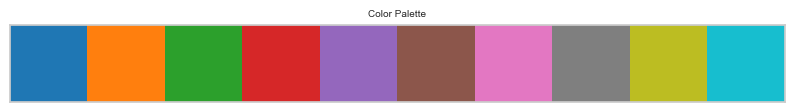

In [3]:
# Define random state, set visualization parameters
RANDOM_STATE = 98
fig_width = get_screen_width() / 100
font_sizes = set_font_size()
plt.rcParams.update(font_sizes)
pd.set_option('display.max_colwidth', None)
HTML('<style>{}</style>'.format(open('styles.css').read()))

# Color style
color_palette = COLOR_PALETTE
sns.set_theme(font_scale=0.6)
sns.set_palette(color_palette)
sns.set_style('whitegrid', {'axes.grid' : False})
sns.palplot(color_palette)
plt.title('Color Palette')
plt.show()

## Dataset Import

In [4]:
DATA_PATH = 'data'
TRAIN_CSV_NAME = 'train.csv'
TEST_CSV_NAME = 'test.csv'

df_train = pd.read_csv(os.path.join(DATA_PATH, TRAIN_CSV_NAME))
df_test = pd.read_csv(os.path.join(DATA_PATH, TEST_CSV_NAME))
df_list = [df_train, df_test]

In [5]:
df_test.head().T

,0,1,2,3,4
PassengerId,0013_01,0018_01,0019_01,0021_01,0023_01
HomePlanet,Earth,Earth,Europa,Europa,Earth
CryoSleep,True,False,True,False,False
Cabin,G/3/S,F/4/S,C/0/S,C/1/S,F/5/S
Destination,TRAPPIST-1e,TRAPPIST-1e,55 Cancri e,TRAPPIST-1e,TRAPPIST-1e
Age,27.0,19.0,31.0,38.0,20.0
VIP,False,False,False,False,False
RoomService,0.0,0.0,0.0,0.0,10.0
FoodCourt,0.0,9.0,0.0,6652.0,0.0
ShoppingMall,0.0,0.0,0.0,0.0,635.0


In [6]:
print(f"Dataset size: {df_train.shape[0]+df_test.shape[0]} rows, {df_train.shape[1]} columns")
print(f"Train size:" , df_train.shape, "Test size:" , df_test.shape)

Dataset size: 12970 rows, 14 columns
Train size: (8693, 14) Test size: (4277, 13)


# Data Formatting & Cleaning


## Correct
* Check for duplicates, remove if necessary.
* Check statistical summaries, remove errors.

In [7]:
df_merged = pd.concat(df_list)
duplicate_count = df_merged.duplicated().sum()
print(f"Total rows: {len(df_merged)}")
print(f"Duplicate rows: {duplicate_count}")
duplicates = df_merged[df_merged.duplicated(keep=False)]
sorted_duplicates = duplicates.sort_values(by=list(df_merged.columns))
sorted_duplicates[:10] if len(duplicates) > 0 else None

Total rows: 12970
Duplicate rows: 0


In [8]:
numerical_columns = df_merged.select_dtypes(exclude='object').columns
round(df_merged[numerical_columns].describe(exclude='object'), 2)

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,12700.00,12707.0,12681.00,12664.00,12686.00,12702.00
mean,28.77,222.9,451.96,174.91,308.48,306.79
std,14.39,647.6,1584.37,590.56,1130.28,1180.10
min,0.00,0.0,0.00,0.00,0.00,0.00
25%,19.00,0.0,0.00,0.00,0.00,0.00
50%,27.00,0.0,0.00,0.00,0.00,0.00
75%,38.00,49.0,77.00,29.00,57.00,42.00
max,79.00,14327.0,29813.00,23492.00,22408.00,24133.00


In [9]:
categorical_columns = df_merged.select_dtypes(include='object').columns
round(df_merged.describe(include=['object']), 2)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,VIP,Name,Transported
count,12970,12682,12660,12671,12696,12674,12676,8693
unique,12970,3,2,9825,3,2,12629,2
top,0001_01,Earth,False,G/734/S,TRAPPIST-1e,False,Carry Contrevins,True
freq,1,6865,8079,8,8871,12401,2,4378


In [10]:
categorical_summary = []
for col in df_merged.columns:
    if df_merged[col].dtype == 'object' and col != 'PassengerId':
        unique_values = df_merged[col].unique()
        categorical_summary.append({
            'Column': col,
            'Unique Values Count': len(unique_values),
            'Unique Values': unique_values
        })
pd.DataFrame(categorical_summary)

,Column,Unique Values Count,Unique Values
0,HomePlanet,4,"[Europa, Earth, Mars, nan]"
1,CryoSleep,3,"[False, True, nan]"
2,Cabin,9826,"[B/0/P, F/0/S, A/0/S, F/1/S, F/0/P, F/2/S, G/0/S, F/3/S, B/1/P, F/1/P, G/1/S, F/2/P, nan, F/3/P, F/4/P, F/5/P, G/0/P, F/6/P, E/0/S, D/0/P, C/2/S, F/6/S, C/0/P, F/8/P, G/4/S, F/9/P, D/1/S, D/1/P, F/8/S, F/10/S, G/1/P, G/2/P, B/3/P, G/3/P, F/10/P, E/1/S, E/2/S, G/6/S, F/11/S, A/1/S, G/7/S, F/12/S, F/13/S, F/14/S, E/3/S, G/6/P, G/10/S, F/15/S, E/4/S, F/16/S, F/13/P, F/14/P, F/17/S, D/3/P, C/3/S, F/18/S, F/15/P, C/4/S, G/13/S, F/16/P, G/14/S, C/5/S, F/17/P, E/5/S, G/15/S, G/16/S, F/20/S, G/9/P, A/2/S, G/11/P, F/19/P, G/12/P, F/23/S, F/24/S, G/18/S, F/21/P, D/2/S, G/19/S, B/5/P, E/6/S, B/1/S, F/23/P, G/20/S, F/24/P, D/4/P, A/0/P, F/25/P, G/21/S, F/27/P, F/27/S, E/7/S, D/3/S, E/8/S, G/22/S, F/29/S, D/5/S, G/17/P, G/23/S, G/18/P, E/5/P, ...]"
3,Destination,4,"[TRAPPIST-1e, PSO J318.5-22, 55 Cancri e, nan]"
4,VIP,3,"[False, True, nan]"
5,Name,12630,"[Maham Ofracculy, Juanna Vines, Altark Susent, Solam Susent, Willy Santantines, Sandie Hinetthews, Billex Jacostaffey, Candra Jacostaffey, Andona Beston, Erraiam Flatic, Altardr Flatic, Wezena Flatic, Berers Barne, Reney Baketton, Elle Bertsontry, Justie Pooles, Flats Eccle, Carry Hughriend, Alus Upead, Lyde Brighttt, Philda Brighttt, Almary Brantuarez, Glendy Brantuarez, Mollen Mcfaddennon, Breney Jacostanley, Mael Brantuarez, Terta Mcfaddennon, nan, Penton Fullided, Karard Brookenson, Anyoni Unconary, Ceros Mare, Ginia Morsentley, Coobix Datie, Cinets Datie, Dontch Datie, Ziba Oingwhedly, Luse Butte, Marina Leodger, Loise Wheelez, Jorgie Batthewitt, Margia Moodsey, Ankalik Cylistrand, Jodye Coopelandez, Kayne Coopelandez, Cassa Coopelandez, Zelowl Chmad, Mass Chmad, Sony Lancis, Vivia Johnshines, Elaney Hubbarton, Elson Hickerson, Okulas Tractive, Instab Tractive, Zinoces Tractive, Warry Ayalazquez, Shanya Salez, Sterry Greeves, Colatz Keen, Diandy Pecketton, Ninaha Leeves, Celine Leeves, Velyne Leeves, Cinst Binie, Meremy Brighttt, Nelly Dillines, Thell Brantuarez, Gorn Make, Aldibah Mostedry, Conk Dal, Pon Blité, Spuri Pokerheed, Dellie Vinozarks, Totse Datte, Eaturs Datte, Coren Coopezmaney, Furudah Ellcefulve, Jodye Kinson, Stmeal Sacre, Heremy Santry, Deanne Yorkland, Tinez Yorkland, Gracy Dunnisey, Stald Hewson, Tiney Hewson, Alchium Fictful, Doria Carezquez, Leence Carezquez, Aliey Leetersoney, Thewis Connelson, Book Trad, Ritany Holson, Arlen Mclainez, Shaele Mclainez, Fanne Mclainez, Carry Cleachrand, Coobix Hart, Natald Handertiz, Oline Handertiz, Graviph Aloubtled, ...]"
6,Transported,3,"[False, True, nan]"


<div class="next-steps">
    <h3>Observations</h3>
    <p></p>
    <ol>
        <ul>Medium-sized dataset of 12970 rows, no duplicate values</ul>
        <ul>Roughly 67%-33% train-test split</ul>
        <ul>Spending on amenities shows that majority of people did not spend much (75th percentile), although there are a lot of big spenders that skew the mean</code></ul>
        <ul>Categorical columns contain null values that will have to be dealt with</ul>
        <ul>High cardinality in <code>Name</code> and <code>Cabin</code>. Will be transformed into new features or removed.</ul>
    </ol>
</div>

## Complete
Deal with missing values in the dataset.

In [11]:
train_test_missing_values(df_train, df_test)

,Train #,Train %,Test #,Test %
Age,179,2.1,91.0,2.1
Cabin,199,2.3,100.0,2.3
CryoSleep,217,2.5,93.0,2.2
Destination,182,2.1,92.0,2.2
FoodCourt,183,2.1,106.0,2.5
HomePlanet,201,2.3,87.0,2.0
Name,200,2.3,94.0,2.2
PassengerId,0,0.0,0.0,0.0
RoomService,181,2.1,82.0,1.9
ShoppingMall,208,2.4,98.0,2.3


In [12]:
# null rows excluding rows that have null values in 'Transported'
null_rows = df_merged[df_merged.isnull().any(axis=1) & ~df_merged['Transported'].isnull()].shape[0]
print(f"Number of rows with at least one null value: {null_rows}, or "
      "{null_rows/df_merged.shape[0]*100:.2f}% of the dataset.")

Number of rows with at least one null value: 2087, or {null_rows/df_merged.shape[0]*100:.2f}% of the dataset.


Unfortunately, missing values are not concentrated within a set amount of rows, but spread out among roughly 16% of the total dataset. Removing these features would be wasteful, therefore, we will use the following imputation strategy:
* `Age` - impute using kNN Imputation
* `Cabin` - replace missing values with *Unknown*
* `Destination`, `HomePlanet` - replace missing values with *Unknown*
* `FoodCourt`, `RoomService`, `ShoppingMall`, `Spa`, `VRDeck` - replace missing values with 0
* `VIP`, `CryoSleep` - replace missing values with *Unknown*
* `Name` - remove feature completely due to high cardinality

In [13]:
columns_unknown = ['Cabin', 'Destination', 'HomePlanet', 'VIP', 'CryoSleep']
columns_zero = ['FoodCourt', 'RoomService', 'ShoppingMall', 'Spa', 'VRDeck']
imputer = KNNImputer(n_neighbors=3)

for df in df_list:
    # Replace missing values with Unknown
    for col in columns_unknown:
        df[col] = df[col].fillna('Unknown')
    
    # Replace missing values with 0
    for col in columns_zero:
        df[col] = df[col].fillna(0)
    
    # Drop columns
    df.drop(['Name'], axis=1, inplace=True)

    # Impute missing values
    df['Age'] = imputer.fit_transform(df[['Age']])

In [14]:
train_test_missing_values(df_train, df_test)

,Train #,Train %,Test #,Test %
Age,0,0.0,0.0,0.0
Cabin,0,0.0,0.0,0.0
CryoSleep,0,0.0,0.0,0.0
Destination,0,0.0,0.0,0.0
FoodCourt,0,0.0,0.0,0.0
HomePlanet,0,0.0,0.0,0.0
PassengerId,0,0.0,0.0,0.0
RoomService,0,0.0,0.0,0.0
ShoppingMall,0,0.0,0.0,0.0
Spa,0,0.0,0.0,0.0


In [15]:
print(f"Rows after feature imputations: Train - {df_train.shape[0]} rows, Test - {df_test.shape[0]} rows.")
print(f"Total rows: {df_train.shape[0] + df_test.shape[0]}")

Rows after feature imputations: Train - 8693 rows, Test - 4277 rows.
Total rows: 12970


<div class="next-steps">
    <h3>Observations</h3>
    <p></p>
    <ol>
        <ul>16% of rows had at least one missing value</ul>
        <ul>After imputations, no rows were removed</ul>
        <ul>Categorical columns null values changed to <b>Unknown</b></ul>
        <ul>Spending columns null values changed to zeroes</ul>
        <ul><code>Name</code> removed due to high cardinality and no potentially useful information</ul>
    </ol>
</div>

## Create
Create additional features based on provided dataset context to improve EDA.

In [16]:
spending_columns = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
for df in df_list:
    # Split Passenger ID into ID and Group
    df[['Group', 'MemberNum']] = df['PassengerId'].str.split('_', expand=True)

    # Members in group
    df['MemberNum'] = df['MemberNum'].astype(int)
    df['GroupMembers'] = df.groupby('Group')['MemberNum'].transform('max')
    df['SinglePassenger'] = df['GroupMembers'] == 1

    # Split Cabin information
    df[['CabinDeck', 'CabinNumber', 'CabinSide']] = df['Cabin'].str.split('/', expand=True)
    df['CabinSide'] = df['CabinSide'].fillna('Unknown')

    # Spending on amenities
    df['TotalSpending'] = df[spending_columns].sum(axis=1)
    threshold = df['TotalSpending'].quantile(0.75)
    df['BigSpender'] = df['TotalSpending'] > threshold

    # Remove unneeded columns
    df.drop(['Group', 'Cabin', 'CabinNumber', 'MemberNum'], axis=1, inplace=True)

df_train.drop('PassengerId', axis=1, inplace=True)    
df_merged = pd.concat(df_list)
df_train.head().T

,0,1,2,3,4
HomePlanet,Europa,Earth,Europa,Europa,Earth
CryoSleep,False,False,False,False,False
Destination,TRAPPIST-1e,TRAPPIST-1e,TRAPPIST-1e,TRAPPIST-1e,TRAPPIST-1e
Age,39.0,24.0,58.0,33.0,16.0
VIP,False,False,True,False,False
RoomService,0.0,109.0,43.0,0.0,303.0
FoodCourt,0.0,9.0,3576.0,1283.0,70.0
ShoppingMall,0.0,25.0,0.0,371.0,151.0
Spa,0.0,549.0,6715.0,3329.0,565.0
VRDeck,0.0,44.0,49.0,193.0,2.0


## Convert
Review and change columns` datatypes, if necessary.

In [17]:
df_merged.info(memory_usage=False)

<class 'pandas.core.frame.DataFrame'>
Index: 12970 entries, 0 to 4276
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   HomePlanet       12970 non-null  object 
 1   CryoSleep        12970 non-null  object 
 2   Destination      12970 non-null  object 
 3   Age              12970 non-null  float64
 4   VIP              12970 non-null  object 
 5   RoomService      12970 non-null  float64
 6   FoodCourt        12970 non-null  float64
 7   ShoppingMall     12970 non-null  float64
 8   Spa              12970 non-null  float64
 9   VRDeck           12970 non-null  float64
 10  Transported      8693 non-null   object 
 11  GroupMembers     12970 non-null  int32  
 12  SinglePassenger  12970 non-null  bool   
 13  CabinDeck        12970 non-null  object 
 14  CabinSide        12970 non-null  object 
 15  TotalSpending    12970 non-null  float64
 16  BigSpender       12970 non-null  bool   
 17  PassengerId      4

<div class="next-steps">
    <h3>Observations</h3>
    <p></p>
    <ol>
        <ul>Binary-like columns cannot be converted to 1 or 0 due to <b>Unknown</b> values</ul>
        <ul>Categorical columns will assume data types of <b>object</b> and <b>bool</b></ul>
    </ol>
</div>

## Data Summary & Distribution
### Numerical Data

In [18]:
numerical_columns = df_merged.select_dtypes(exclude=['object', 'bool']).columns
round(df_merged[numerical_columns].describe(), 2)

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,GroupMembers,TotalSpending
count,12970.00,12970.00,12970.00,12970.00,12970.00,12970.00,12970.00,12970.00
mean,28.77,218.38,441.89,170.78,301.72,300.45,2.02,1433.22
std,14.24,641.77,1568.04,584.15,1118.75,1168.66,1.58,2807.37
min,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
25%,20.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
50%,27.00,0.00,0.00,0.00,0.00,0.00,1.00,716.00
75%,37.00,42.75,62.75,23.00,50.00,36.00,2.00,1442.00
max,79.00,14327.00,29813.00,23492.00,22408.00,24133.00,8.00,35987.00


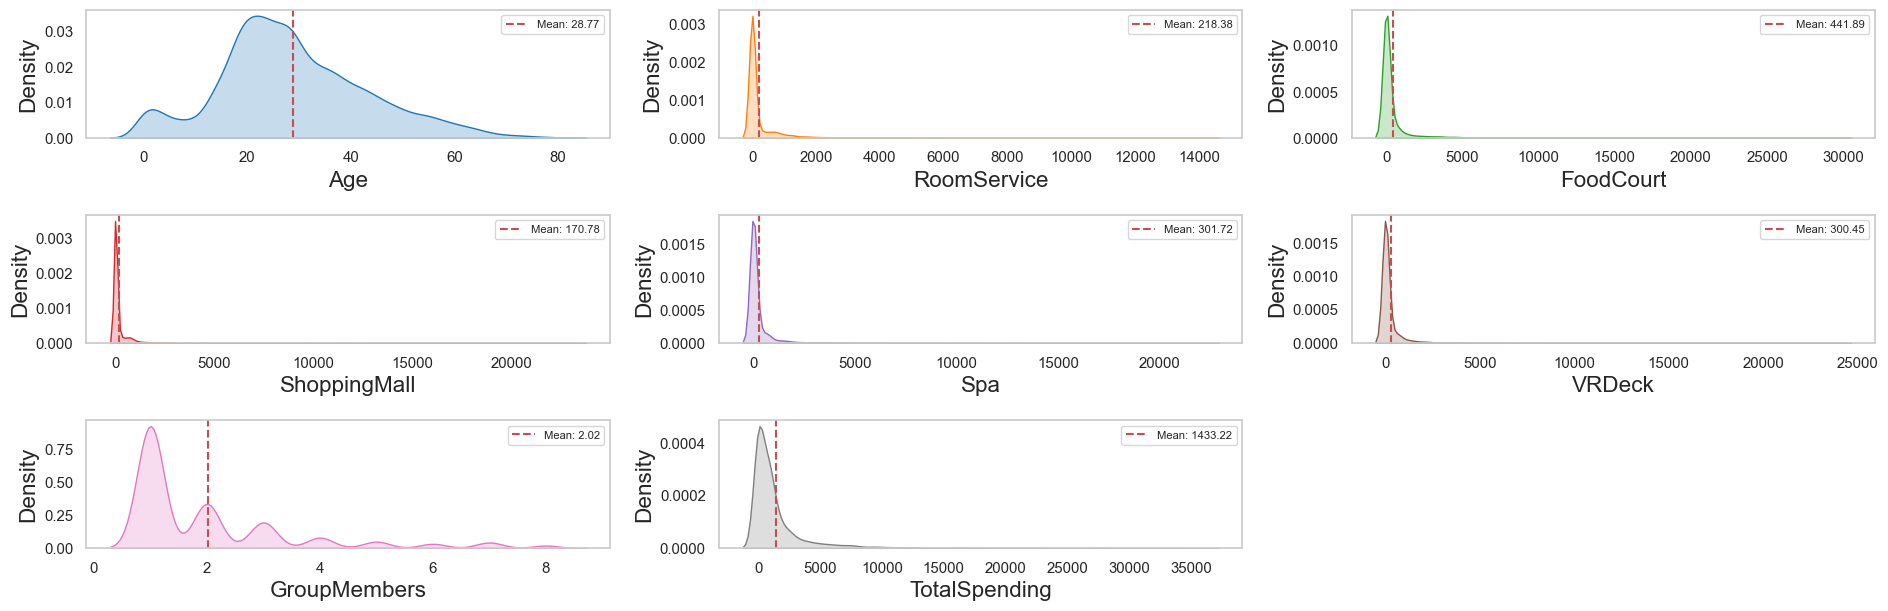

In [19]:
draw_numerical_distributions(df_merged, numerical_columns, chart_type='kde')

<div class="next-steps">
    <h3>Observations</h3>
    <p></p>
    <ol>
        <ul>Age has resemblence to a normal distribution, where the mean is about 29 years old</ul>
        <ul>Most of the passengers were not big spenders, with the average biggest spending in <code>FoodCourt</code></ul>
        <ul>A lot of passengers were travelling alone, but the average group size is 2 passengers</ul>
    </ol>
</div>

## Categorical Data

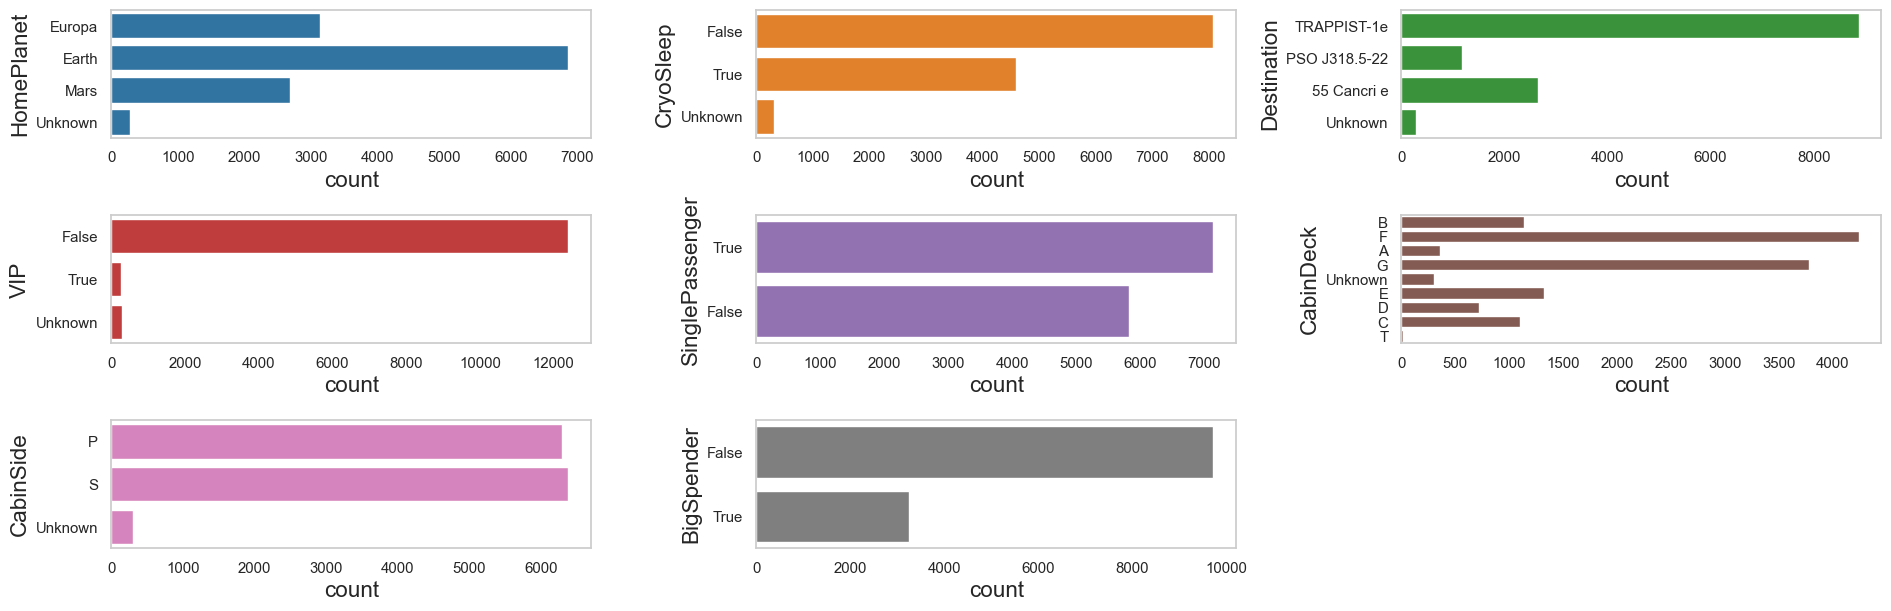

In [20]:
categorical_columns = df_merged.select_dtypes(include=['object', 'bool']).columns
categorical_columns = categorical_columns.drop('PassengerId')
draw_categorical_distributions(df_merged, cols_list=exclude_list_value(categorical_columns, 'Transported'), grid_cols=3)

<div class="next-steps">
    <h3>Observations</h3>
    <p></p>
    <ol>
        <ul>Majority of passengers are from Earth</ul>
        <ul>Only about a third of the passengers were in Cryo Sleep</ul>
        <ul>Most passengers were headed to TRAPPIST-1e</ul>
        <ul>Majority of passengers were not VIP</ul>
        <ul>More than half of passengers were travelling by themselves</ul>
        <ul>P and S Cabin sides are almost equally split, and F and G Cabin Decks were the most prevalent</ul>
        <ul>Only about a quarter of passengers can be classified as big spenders</ul>
    </ol>
</div>

# Exploratory Data Analysis
Let's explore the target variable and it's relationship to predictor variables.

## Target variable

In [21]:
target_col = 'Transported'
value_counts = df_train[target_col].value_counts()
percentage_of_total = round((value_counts / value_counts.sum()) * 100, 2)
result = pd.DataFrame({
    'Value Counts': value_counts,
    'Percentage of Total (%)': percentage_of_total
})
result

,Value Counts,Percentage of Total (%)
Transported,,
True,4378,50.36
False,4315,49.64


A very-well balanced dataset, having an almost equal 50/50 split.

## Numerical predictors

Feature: Age. p-value: 0.0000. Effect size: 0.0804


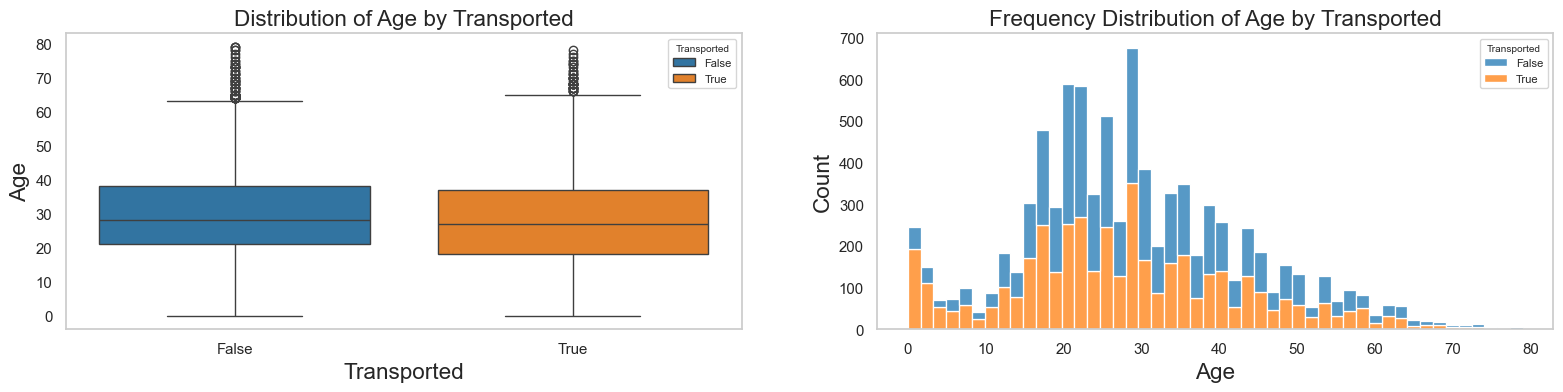

Feature: RoomService. p-value: 0.0000. Effect size: 0.4954


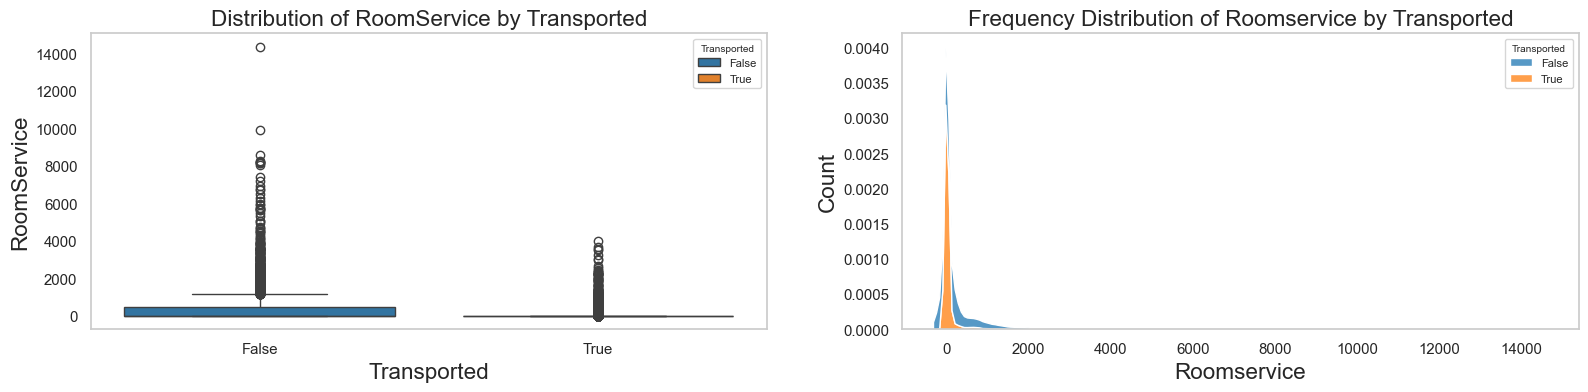

Feature: FoodCourt. p-value: 0.0000. Effect size: -0.0914


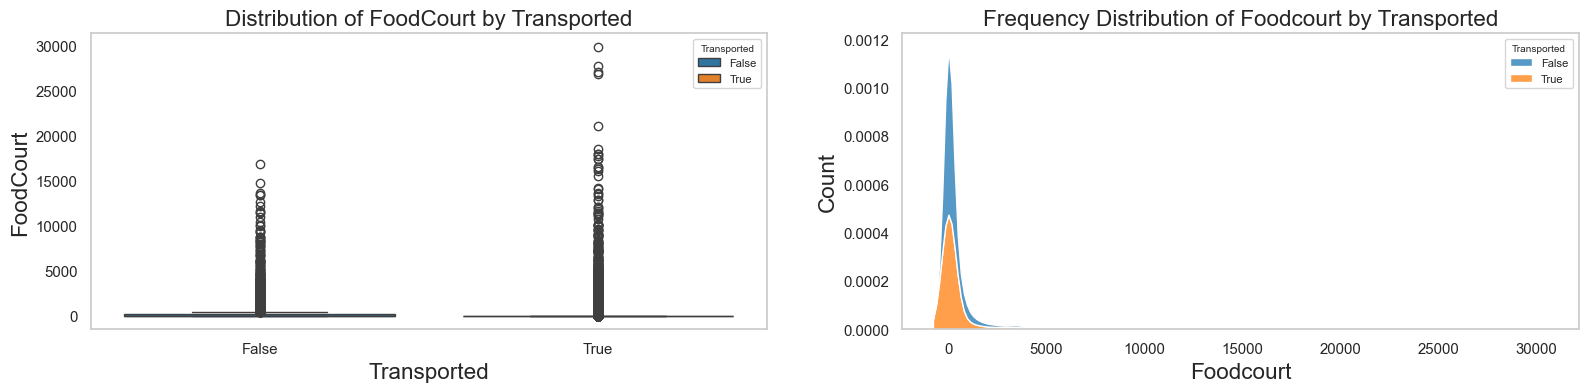

Feature: ShoppingMall. p-value: 0.0000. Effect size: -0.0188


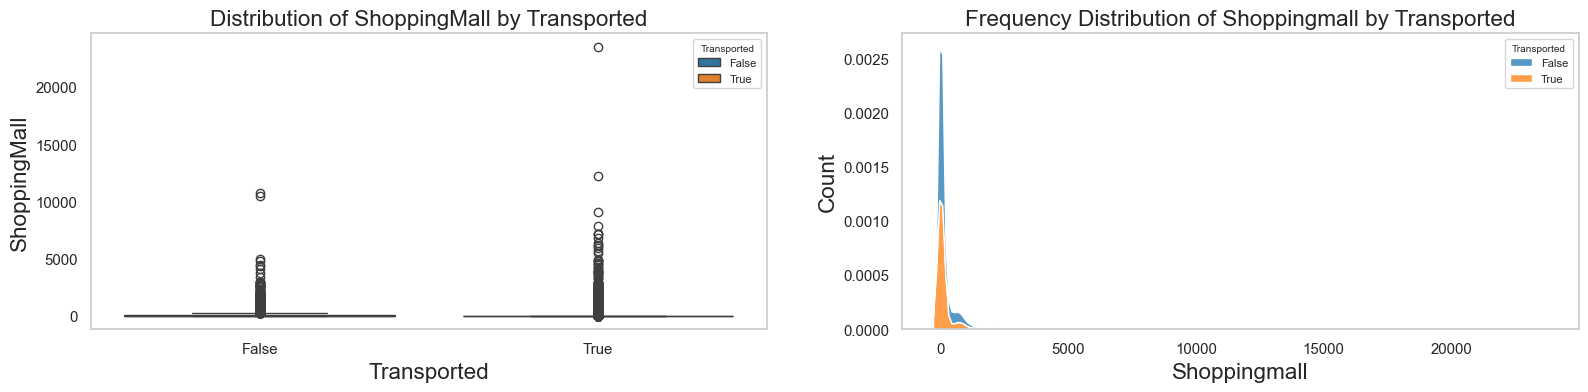

Feature: Spa. p-value: 0.0000. Effect size: 0.4463


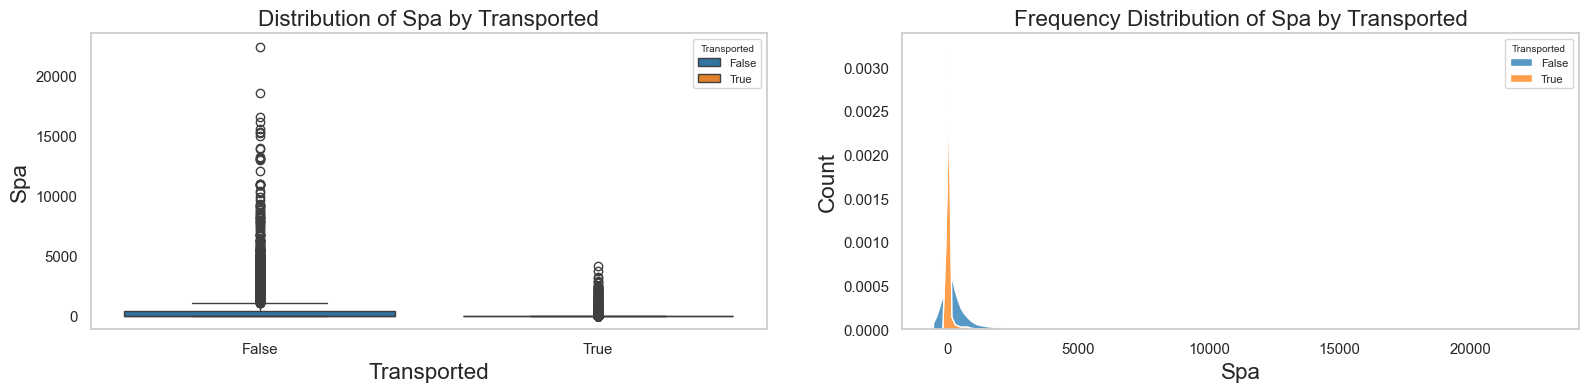

Feature: VRDeck. p-value: 0.0000. Effect size: 0.4172


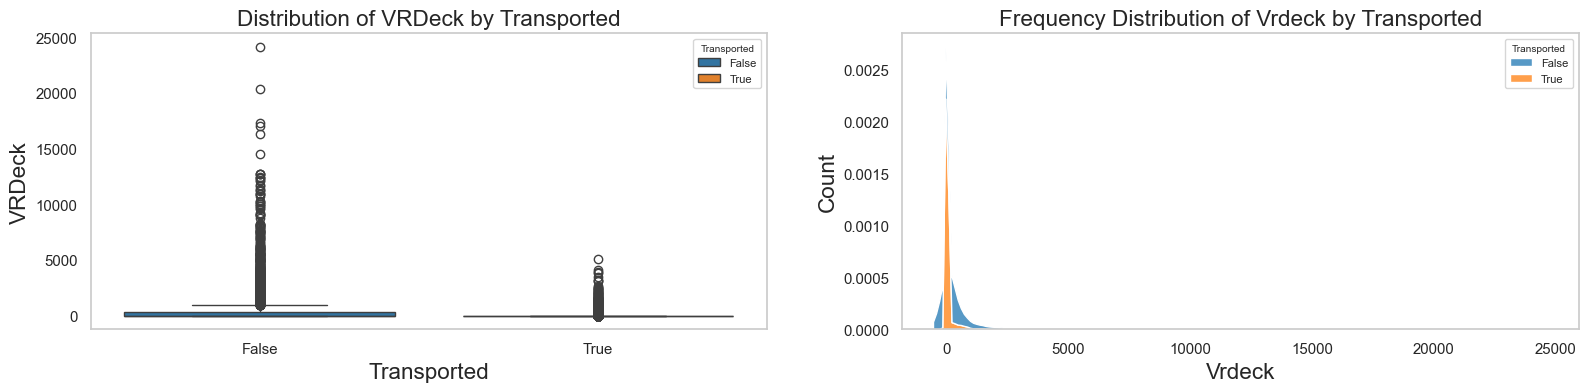

Feature: GroupMembers. p-value: 0.0000. Effect size: -0.1202


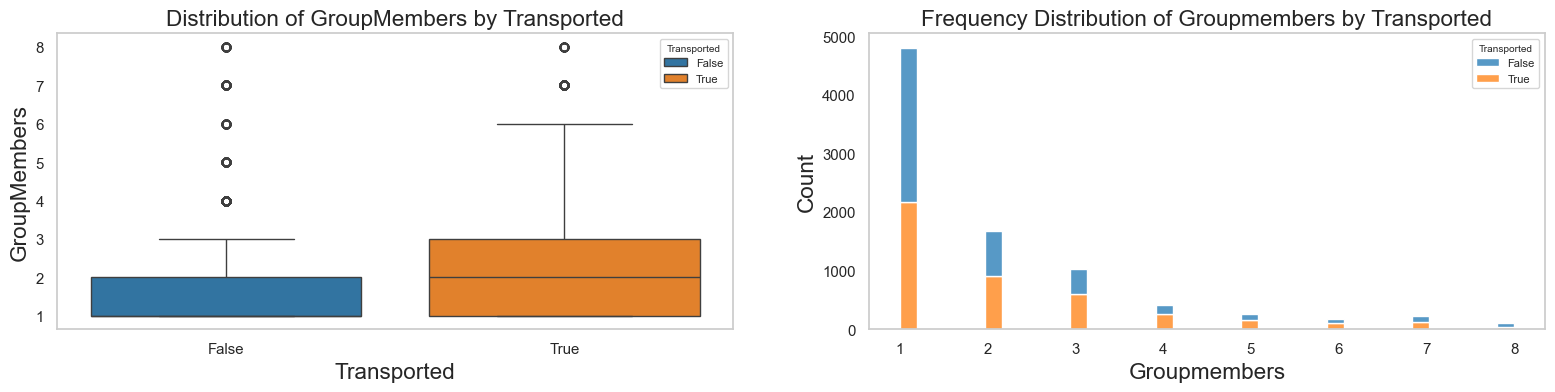

Feature: TotalSpending. p-value: 0.0000. Effect size: 0.4067


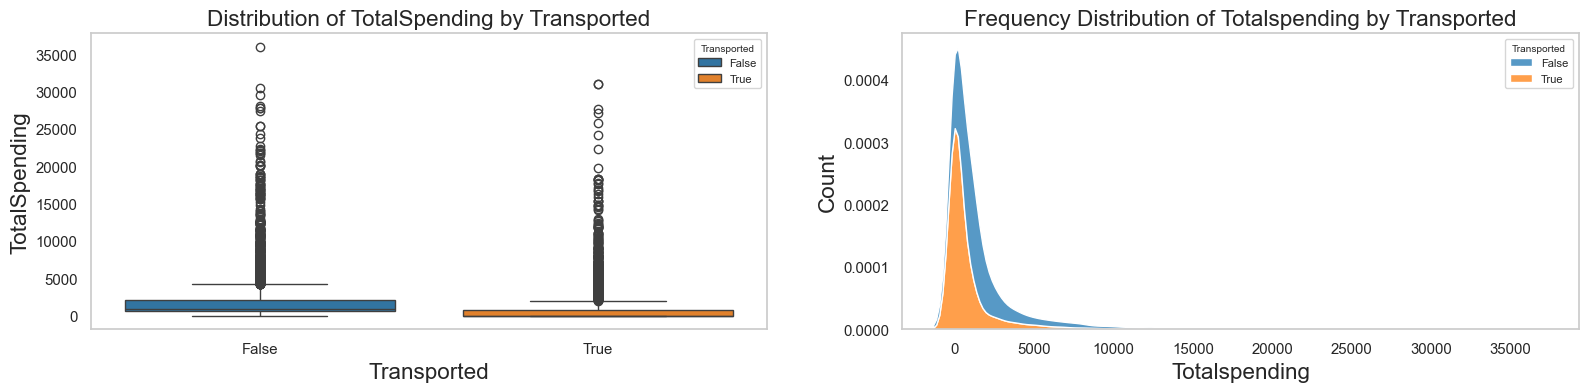

,Column,Test Name,P-value,Test Statistic,Effect Size,Median Group 0,Median Group 1,Significance,Effect Magnitude
0,Age,Mann-Whitney U test,0.0,10205151.00,0.0804,28.0,27.0,Statistically significant,negligible
1,RoomService,Mood's median test,0.0,1050.85,0.4954,1.0,0.0,Statistically significant,medium
2,FoodCourt,Mood's median test,0.0,470.21,-0.0914,0.0,0.0,Statistically significant,small
3,ShoppingMall,Mood's median test,0.0,603.80,-0.0188,0.0,0.0,Statistically significant,small
4,Spa,Mood's median test,0.0,1027.57,0.4463,2.0,0.0,Statistically significant,medium
5,VRDeck,Mood's median test,0.0,957.79,0.4172,1.0,0.0,Statistically significant,medium
6,GroupMembers,Mann-Whitney U test,0.0,8309879.00,-0.1202,1.0,2.0,Statistically significant,negligible
7,TotalSpending,Mood's median test,0.0,1413.28,0.4067,907.0,0.0,Statistically significant,medium


In [22]:
df_significance_num = pd.DataFrame()
hist_type = {num_col: ('histogram' if num_col == 'Age' or num_col == 'GroupMembers' else 'kde')
             for num_col in numerical_columns}
test_type = {num_col: ('mann_whitney' if num_col == 'Age' or num_col == 'GroupMembers' else 'moods_median')
             for num_col in numerical_columns}

for num_col in numerical_columns:
    result = numerical_predictor_significance_test(df_train, predictor=num_col,
                                                   target=target_col, test_type=test_type[num_col])
    df_significance_num = interpret_results_numerical(df_significance_num, result, col_name=num_col)
    print(f"Feature: {num_col}. p-value: {result['p_value']:.4f}. Effect size: {result['effect_size']:.4f}")
    draw_predictor_numerical_plots(df_train, predictor=num_col, target=target_col, hist_type=hist_type[num_col])

df_significance_num

<div class="next-steps">
    <h3>Observations</h3>
    <p></p>
    <ol>
        <ul>All differences between features and label distributions were regarded as statistically significant, yet only some spending-related features had a significant effect magnitude</ul>
        <ul>Age and the size of the group seem to be negligible in determining whether the passenger was transported or not</ul>
        <ul>Differences in spending between the two groups seems to indicate that big spenders were slightly less likely to be transported</ul>
        <ul>For passengers who were transported, <code>RoomService</code>, <code>VRDeck</code> and <code>Spa</code> spendings seem to have a smaller, narrowed range compared to non-transported passengers</ul>
    </ol>
</div>

## Categorical Predictors

Feature: HomePlanet. p-value: 0.0000. Effect size: 0.1933


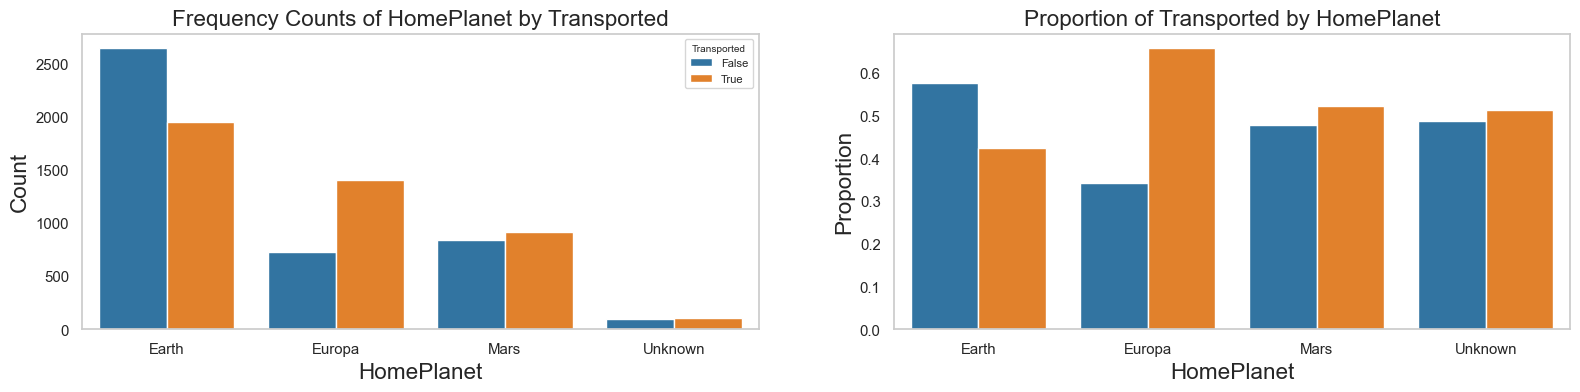

Feature: CryoSleep. p-value: 0.0000. Effect size: 0.4628


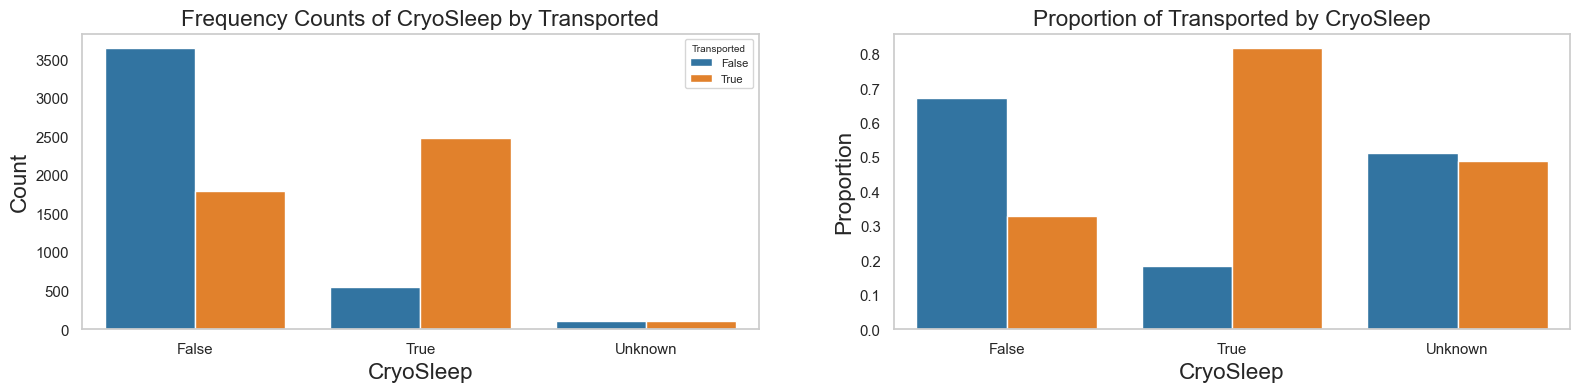

Feature: Destination. p-value: 0.0000. Effect size: 0.1106


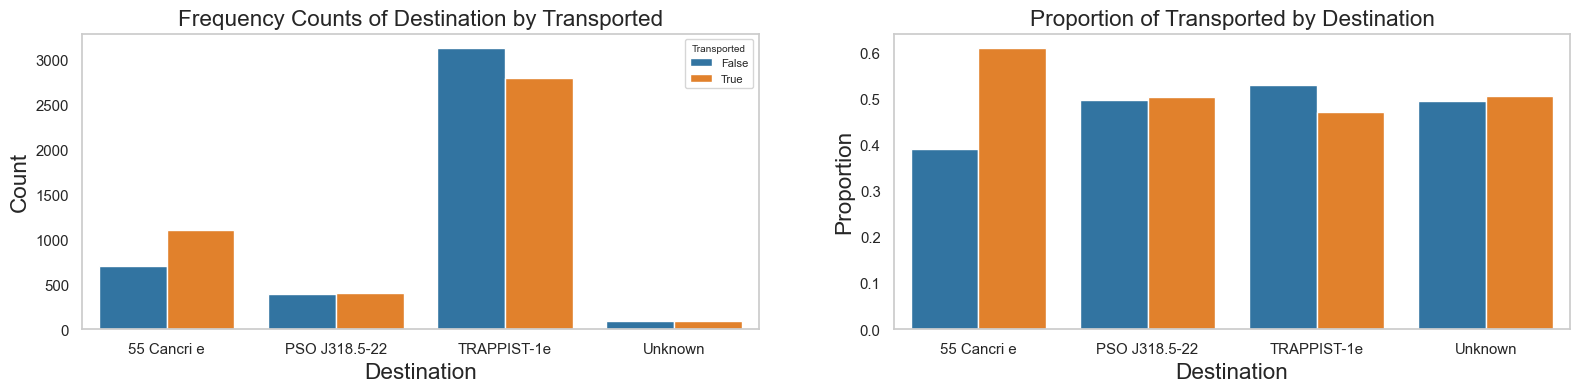

Feature: VIP. p-value: 0.0024. Effect size: 0.0373


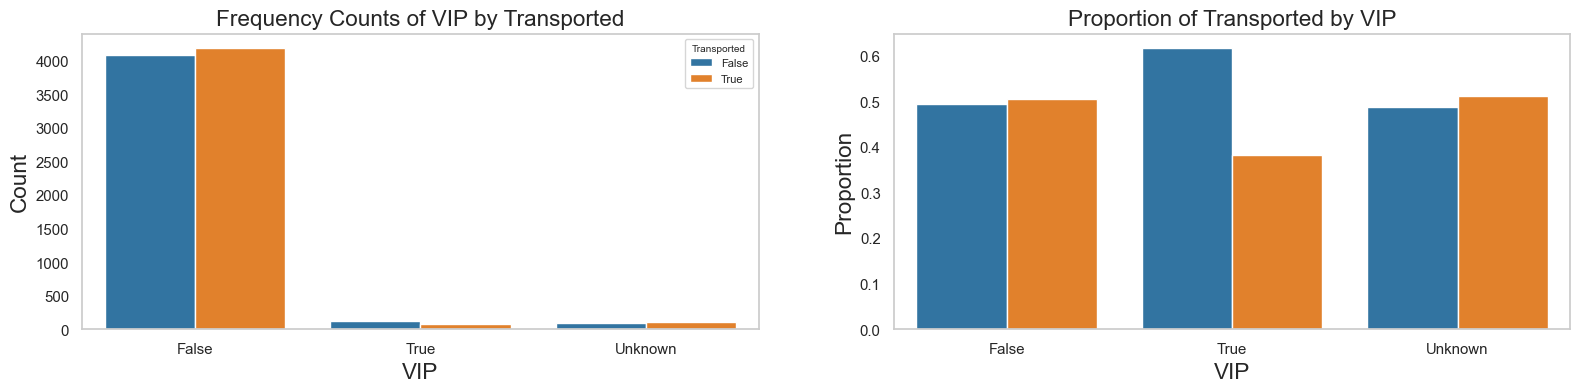

Feature: SinglePassenger. p-value: 0.0000. Effect size: 0.1136


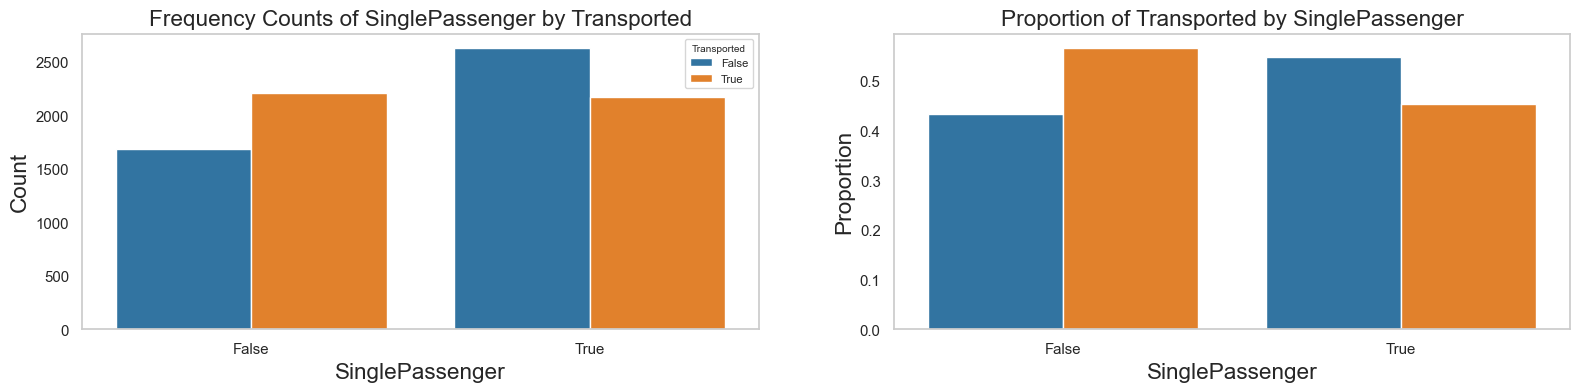

Feature: CabinDeck. p-value: 0.0000. Effect size: 0.2124


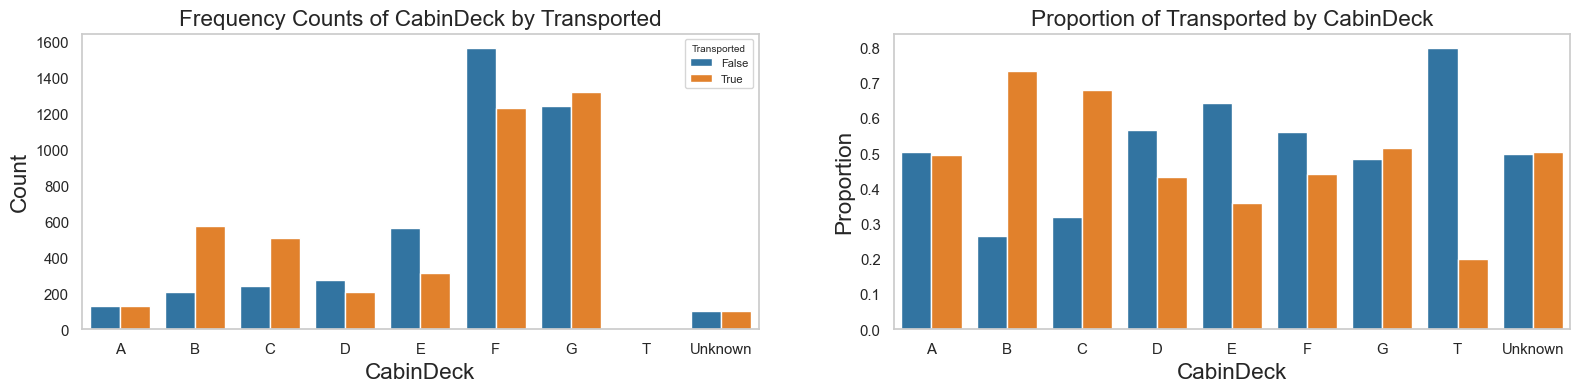

Feature: CabinSide. p-value: 0.0000. Effect size: 0.1026


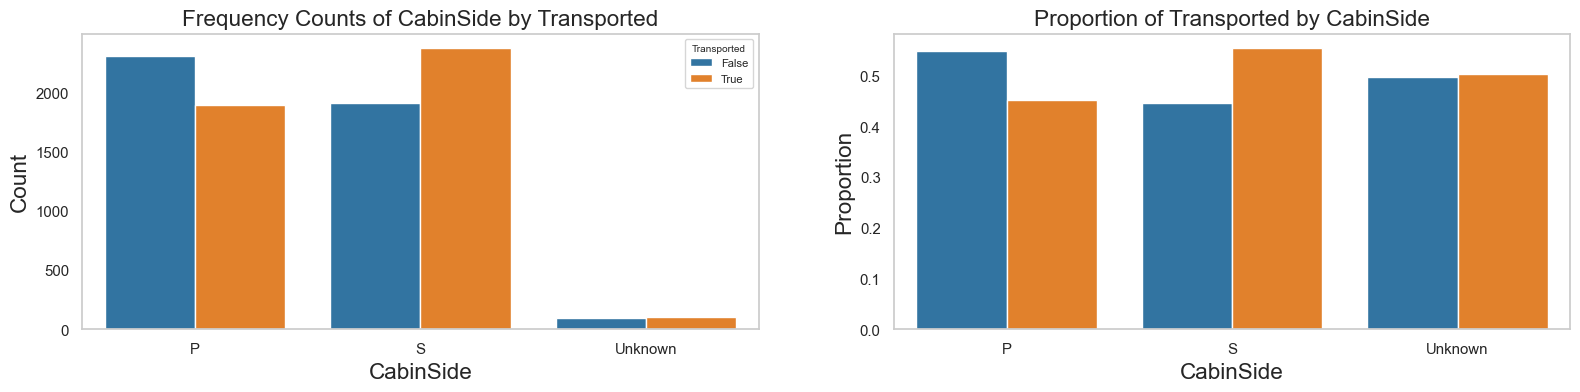

Feature: BigSpender. p-value: 0.0000. Effect size: 0.2279


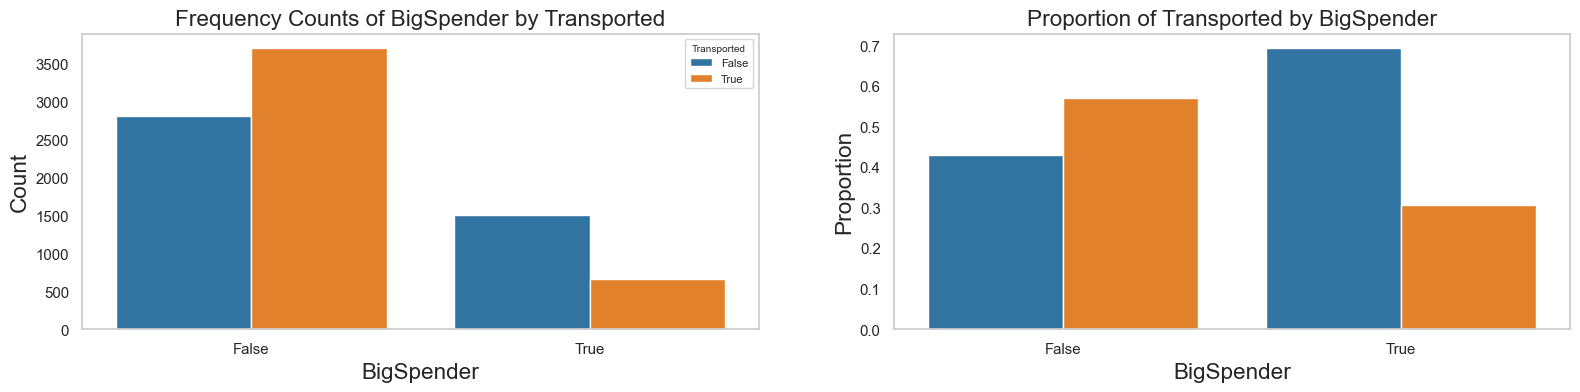

,Column,Test Name,P-value,Chi-squared statistic,Degrees of freedom,Effect size (Cramer's V),Significance,Effect Magnitude
0,HomePlanet,Chi-squared test,0.000000,324.97,3,0.1933,Statistically significant,small
1,CryoSleep,Chi-squared test,0.000000,1861.75,2,0.4628,Statistically significant,medium
2,Destination,Chi-squared test,0.000000,106.39,3,0.1106,Statistically significant,small
3,VIP,Chi-squared test,0.002361,12.10,2,0.0373,Statistically significant,negligible
4,SinglePassenger,Chi-squared test,0.000000,112.10,1,0.1136,Statistically significant,small
5,CabinDeck,Chi-squared test,0.000000,392.29,8,0.2124,Statistically significant,small
6,CabinSide,Chi-squared test,0.000000,91.48,2,0.1026,Statistically significant,small
7,BigSpender,Chi-squared test,0.000000,451.44,1,0.2279,Statistically significant,small


In [23]:
df_significance_cat = pd.DataFrame()
for cat_col in exclude_list_value(categorical_columns, target_col):
    result = categorical_predictor_significance_test(df_train, predictor=cat_col, target=target_col)
    df_significance_cat = interpret_results_categorical(df_significance_cat, result, col_name=cat_col)
    print(f"Feature: {cat_col}. p-value: {result['p_value']:.4f}. Effect size: {result['effect_size']:.4f}")
    draw_predictor_categorical_plots(df_train, predictor=cat_col, target=target_col)
    
df_significance_cat

<div class="next-steps">
    <h3>Observations</h3>
    <p></p>
    <ol>
        <ul>All differences between features and label distributions were regarded as statistically significant, yet only <code>CryoSleep</code> had a significant effect magnitude</ul>
        <ul><b>Europe</b> and <b>Mars</b> passengers seemed to have a larger rate of being transported</ul>
        <ul>Passengers in <b>CryoSleep</b> had a much larger rate of being transported</ul>
        <ul>Passengers in groups of 2+ had a slightly larger transported rate</ul>
        <ul>Passengers in <b>B</b> and <b>C</b> cabin decks had a larger transported rate</ul>
        <ul>Big Spenders were less likely to be transported - most likely because the transportation could've happened early or midway the trip</ul>
    </ol>
</div>

## Feature Transformation
To improve model performance, let's log transform numerical features where the skewness exceeds a threshold. This will benefit in the following:
1. Many ML algorithms perform better with normalized data
2. Reduces skewness, which is especially prevalent in our data & makes outliers less influential
3. Stabilizes the variance of data, making it more uniform

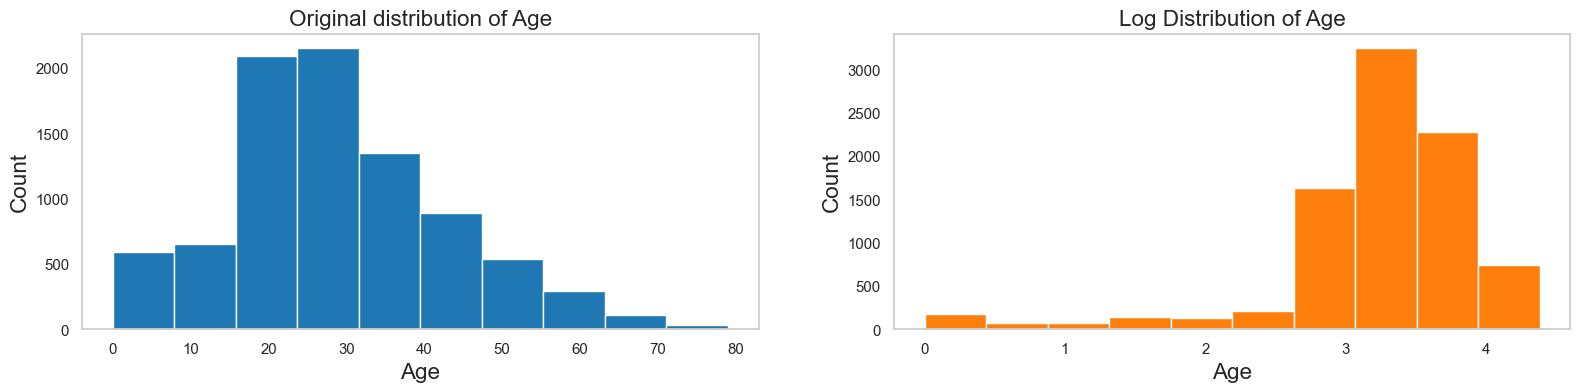

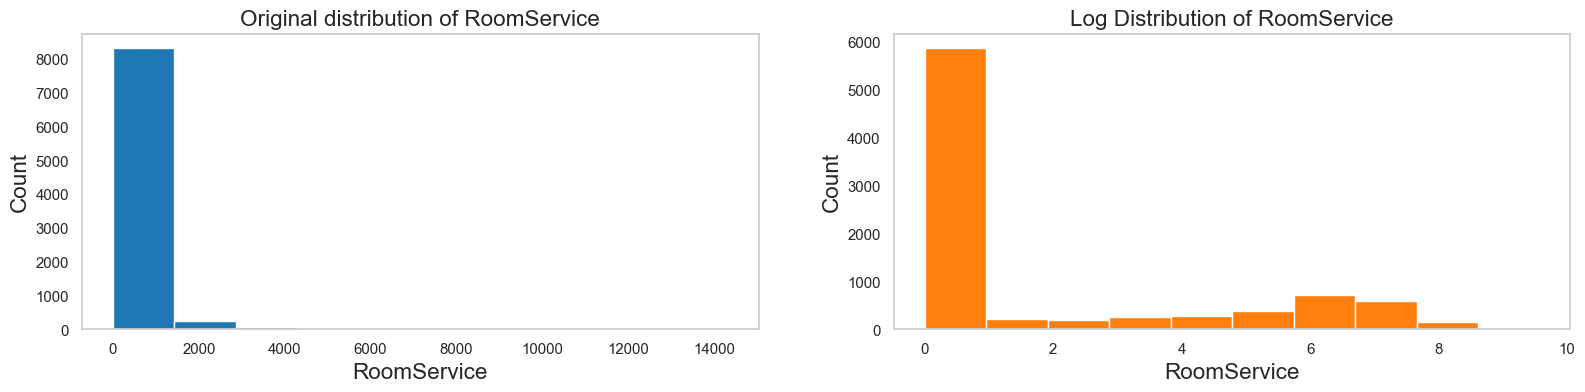

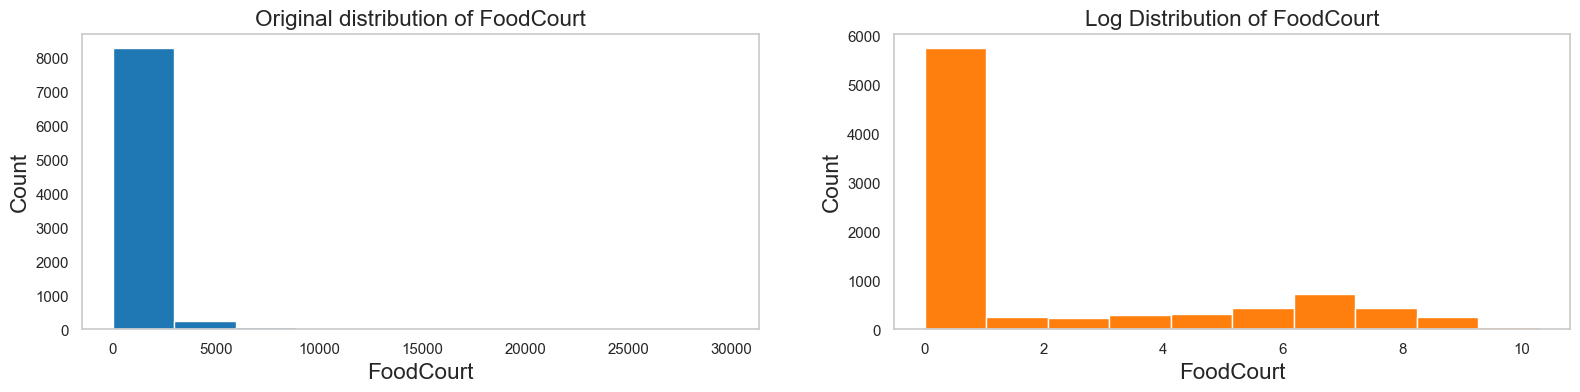

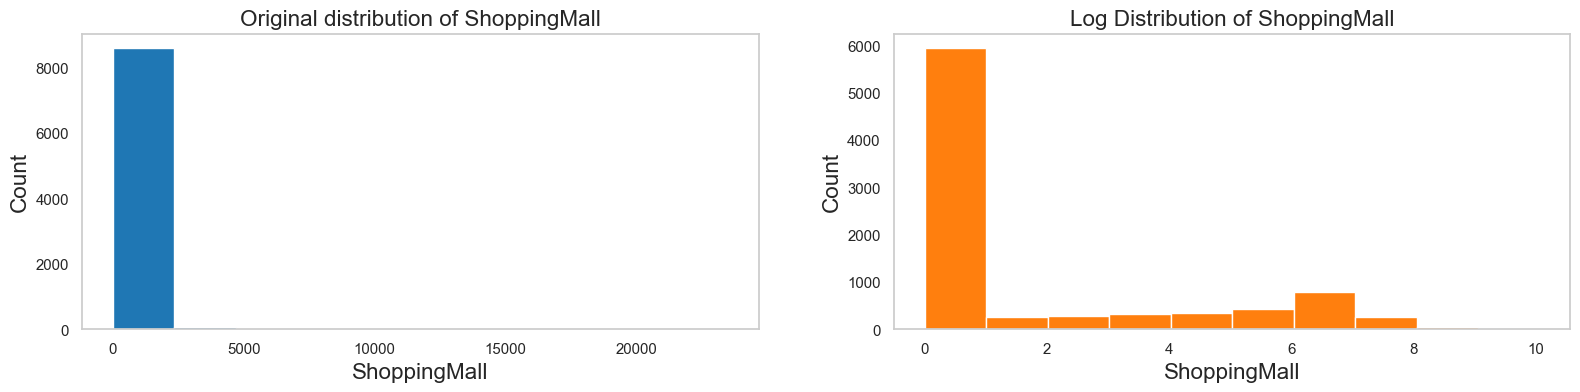

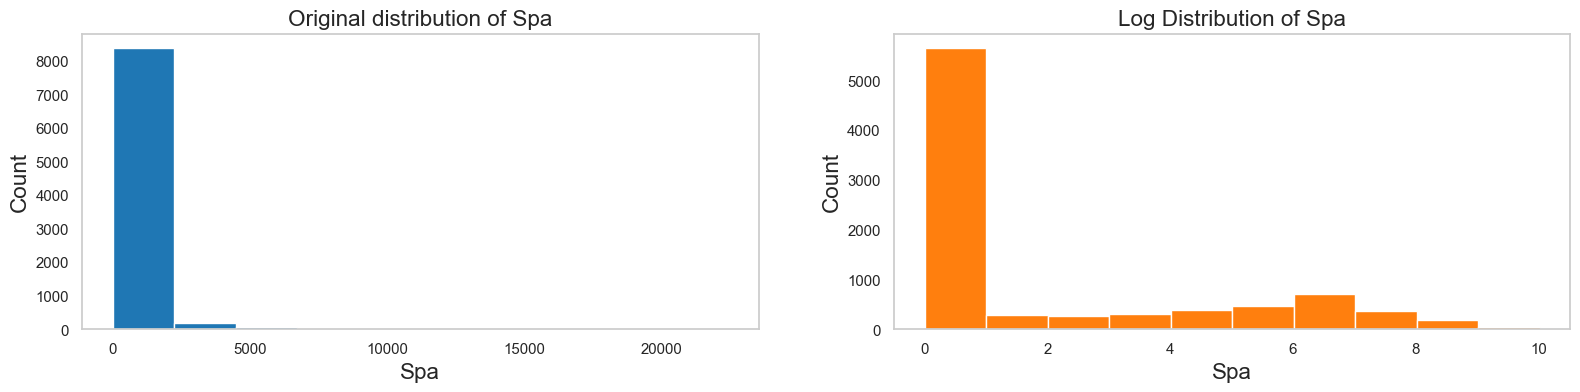

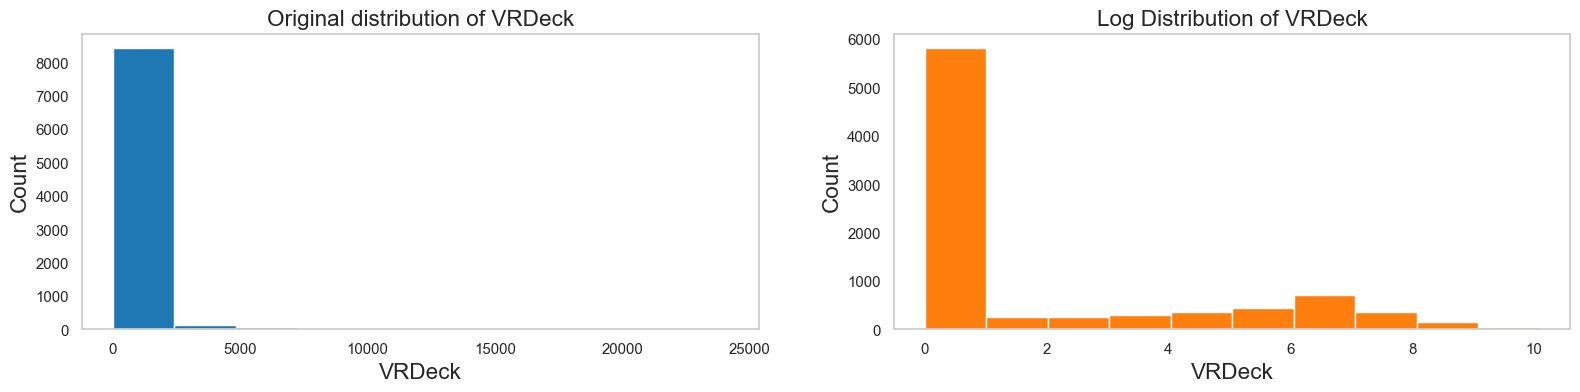

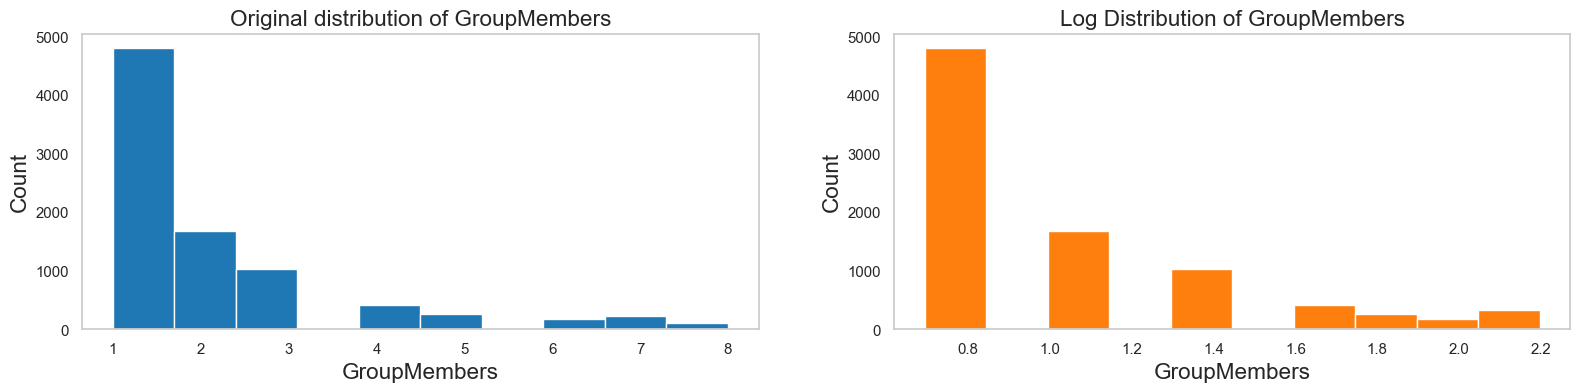

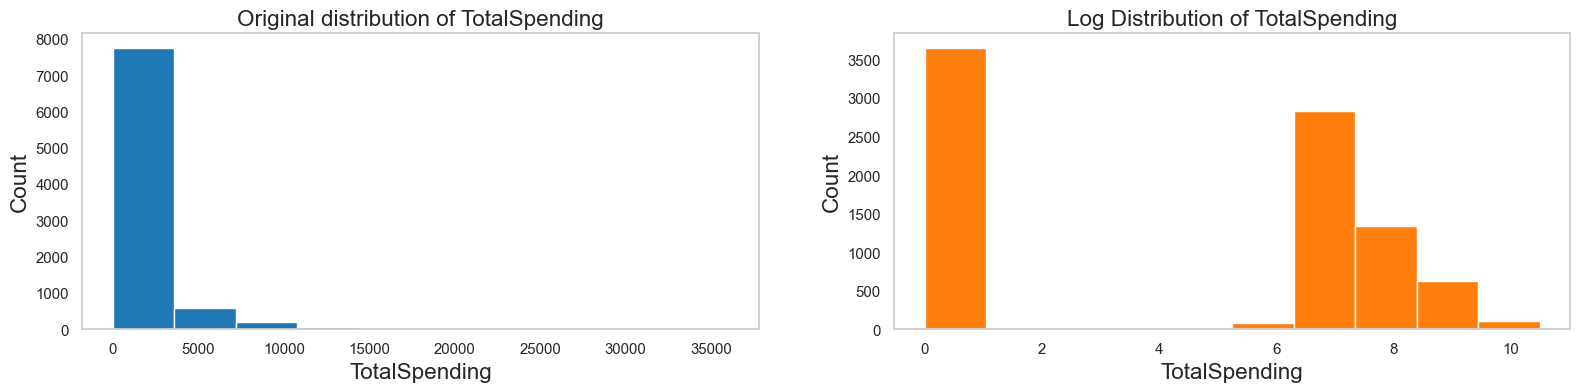

In [24]:
df_skewness = pd.DataFrame()
for num_feature in numerical_columns:
    draw_original_log_distribution(df_train, num_feature)
    df_skewness = calculate_skewness(df_train, num_feature, df_skewness)

In [25]:
df_skewness

,Feature,Skewness,Log transform
0,Age,0.423478,No
1,RoomService,6.397766,Yes
2,FoodCourt,7.177515,Yes
3,ShoppingMall,12.763842,Yes
4,Spa,7.716450,Yes
5,VRDeck,7.904554,Yes
6,GroupMembers,1.889017,Yes
7,TotalSpending,4.417588,Yes


In [26]:
log_columns = df_skewness.loc[df_skewness['Log transform'] == 'Yes', 'Feature'].values
for df in df_list:
    for col in log_columns:
        df[f'{col}_log'] = np.log1p(df[col])
    df.drop(columns=log_columns, inplace=True)
numerical_columns = df_train.select_dtypes(include=['float64', 'int64']).columns

All numerical columns except for `Age` were log-transformed.

## Feature Correlations & Importance
Let's see how the variables interact between each other and provide meaningful information to the target variable. We will be using **Phik's Coefficient** and **Mutual Information**.

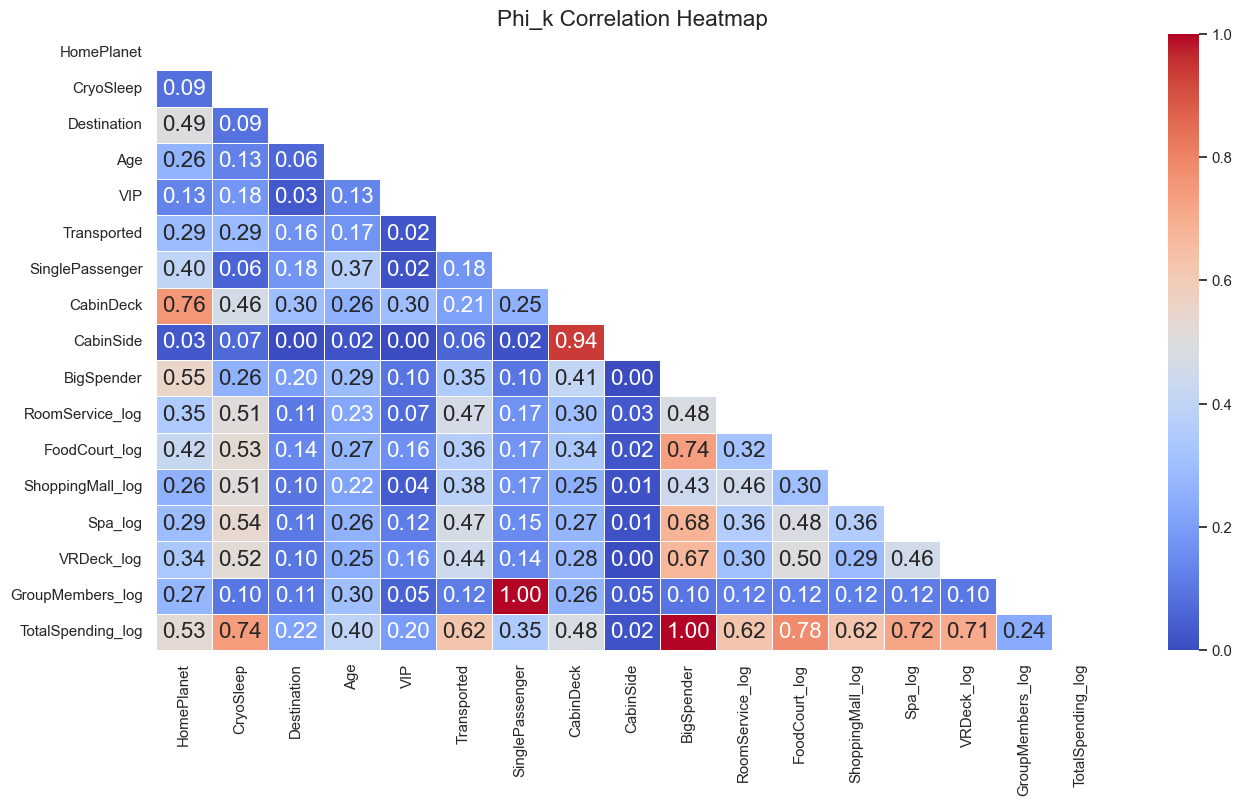

In [27]:
phik_matrix(df_train, numerical_columns)

<div class="findings">
    <h3>Findings</h3>
    <p>Features' correlation</p>
    <ol>
        <ul>The target variable <code>Transported</code> has some weak positive correlations; <code>Transported</code> - <code>TotalSpending_log</code> is the biggest positive correlation</ul>
        <ul><code>TotalSpending_log</code> has some strong correlations with some of it's components and <code>BigSpender</code></ul>
        <ul>Additionally, <code>TotalSpending_log</code> has a strong correlation with <code>CryoSleep</code>. We could explain this with the assumption that people in Cryo Sleep can't spend money on amenities, since it requires for them to be awake</ul>
        <ul><code>CabinDeck</code> seems to be highly influenced by the passenger's <code>HomePlanet</code> and might influence where the <code>CryoSleep</code> passengers were in</ul>
    </ol>
</div>

## Mutual Information
For the Mutual Information part, we will need to encode the categorical features.

In [28]:
df_train_encoded = pd.get_dummies(df_train, columns=exclude_list_value(categorical_columns, target_col),
                                  drop_first=True)

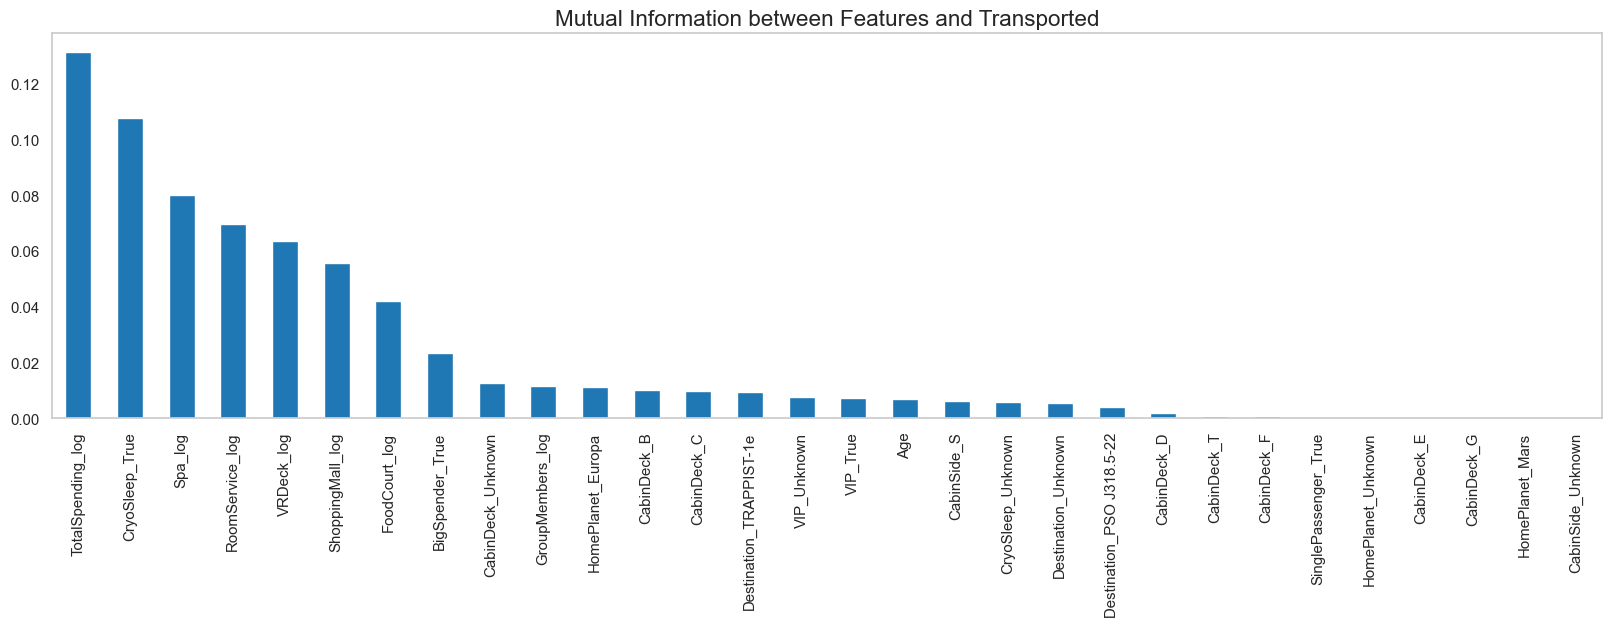

In [29]:
X_mi = df_train_encoded.drop(columns=[target_col], axis=1)
y_mi = df_train_encoded[target_col]

mi = mutual_info_classif(X_mi, y_mi, discrete_features='auto', random_state=RANDOM_STATE)
mi_series = pd.Series(mi, index=X_mi.columns)
plt.figure(figsize=(20, 5))
mi_series.sort_values(ascending=False).plot.bar()
plt.title(f'Mutual Information between Features and {target_col}')
plt.show()

<div class="findings">
    <h3>Findings</h3>
    <p>Mutual Information - Features and Target</p>
    <ol>
        <ul>Spending features seem to eliminate the most uncertainty in predicting whether the passenger was transported or not. Based on the numerical variable analysis, bigger spenders were less likely to be transported</ul>
        <ul>Additionally, Cryo Sleep eliminates a lot of the uncertainty as well. More specifically, passengers which were on Cryo Sleep seem to have been more likely to be transported</ul>
    </ol>
</div>

To summarize EDA, let's try to answer the following questions:
* Is there a visible difference in spendings based on whether the passenger was in Cryo Sleep?
* Is the higher transportation rate in cabins B and C tied to the proportion of passengers who were in Cryo Sleep?
* Is there a notable difference in Cryo Sleep rates among passengers of differing home planets? 

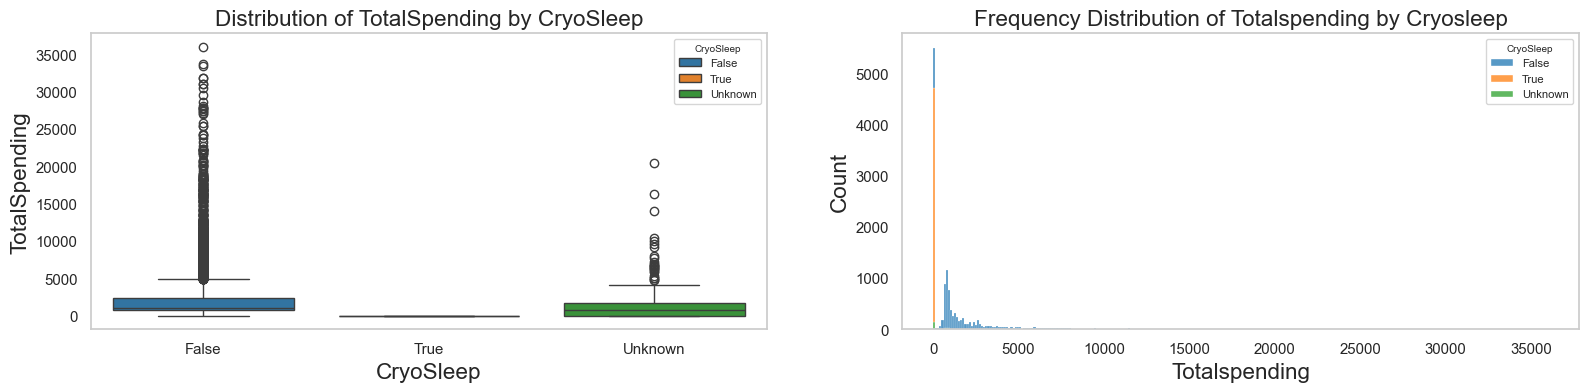

Maximum spending of the passengers in CryoSleep: 0.0


In [30]:
draw_predictor_numerical_plots(df_merged, 'TotalSpending', 'CryoSleep')
print(f"Maximum spending of the passengers in CryoSleep: {df_merged.loc[df_merged['CryoSleep'] == True,
                                                                        'TotalSpending'].max()}")

All passengers who were in Cryo Sleep did not spend any money, hence the `TotalSpending` correlation with `CryoSleep`

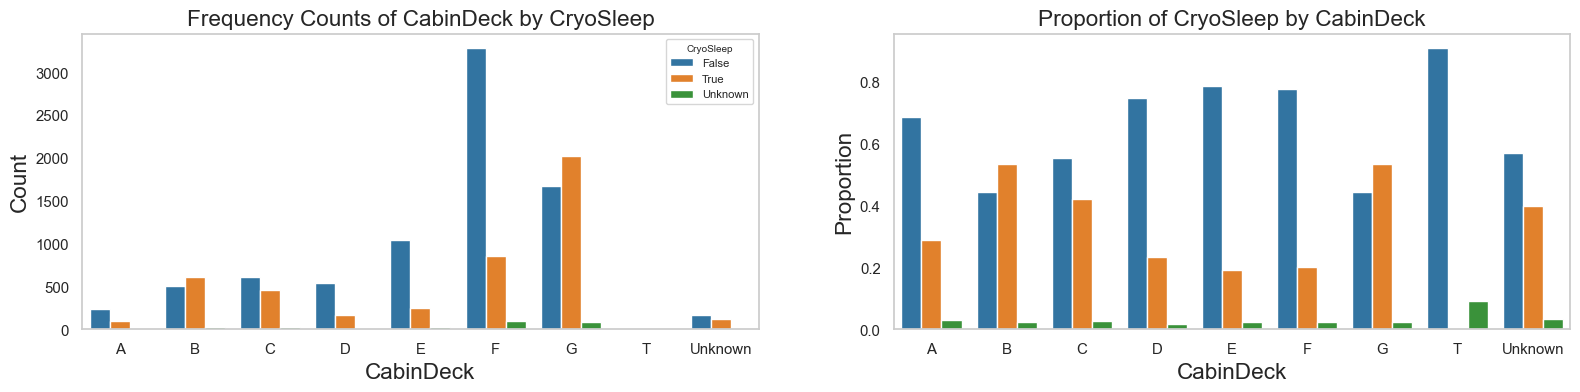

In [31]:
draw_predictor_categorical_plots(df_merged, 'CabinDeck', 'CryoSleep')

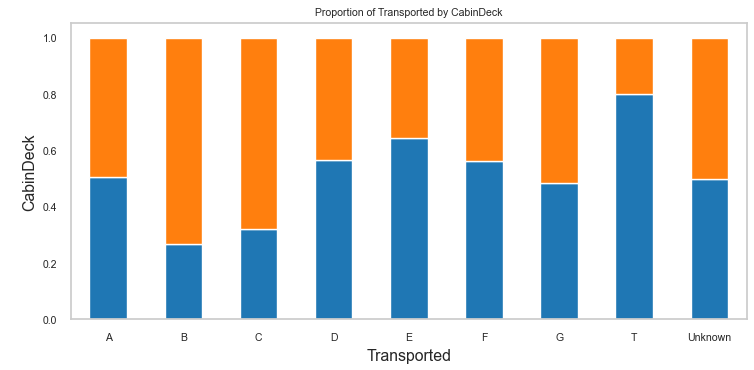

In [32]:
Image(filename='media/Transported by Cabin Deck.png')

Cabins <b>B</b>, <b>C</b> and <b>G</b> had the largest ratio of passengers in Cryo Sleep. Similarly, these cabin decks have the highest ratios of transported passengers.

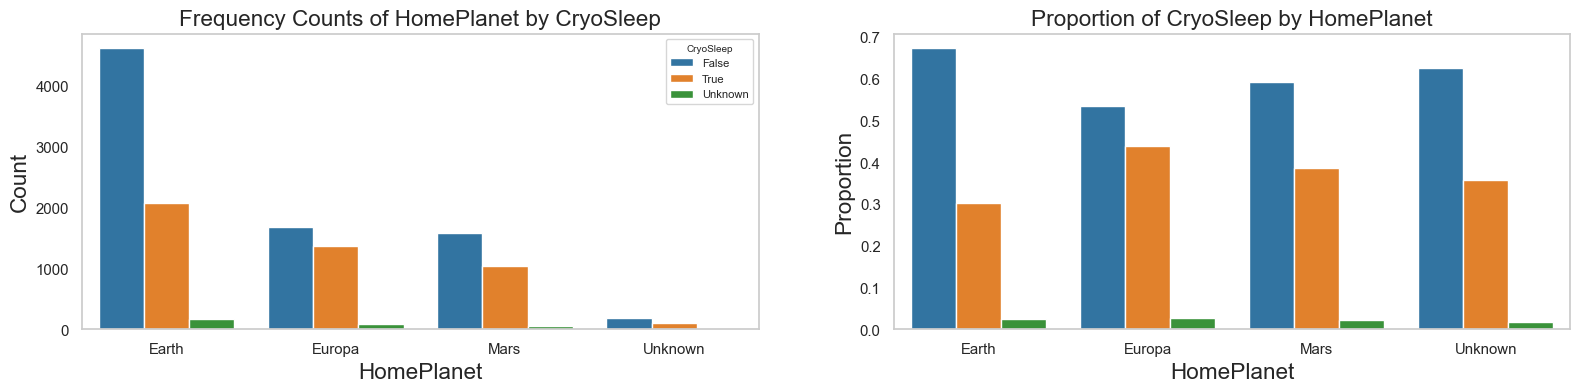

In [33]:
draw_predictor_categorical_plots(df_merged, 'HomePlanet', 'CryoSleep')

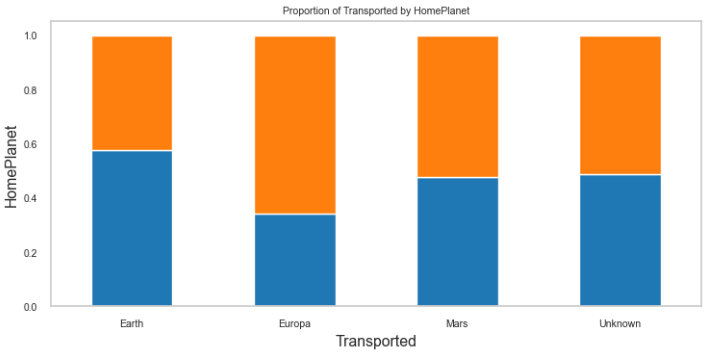

In [34]:
Image(filename='media/Transported by Home Planet.png')

Passengers of Europa had the highest rates of being transported. Similarly, it has the highest ratio of passengers in CryoSleep.

<div class="results">
    <h3>EDA Results</h3>
    <p>Key predictors</p>
    <ol>
        <ul><code>CryoSleep</code> is a key predictor in determining whether a passenger was transported or not</ul>
        <ul><b>Spending-related</b> columns seem to provide a lot of mutual information and correlate well with the <code>Transported</code>, yet it is very closely tied with the <code>CryoSleep</code> value - passengers in Cryo Sleep did not spend any money</ul>
    </ol>
</div>

# Statistical Modeling
* Data Split: **Train-test**
* Performance Metric: **Accuracy**
* Baseline Model: **VotingClassifier ensemble of six models**

The baseline will use `df_train_raw` - the initial training dataset with all original features. Additionally, we will perform these steps:
* Missing values imputation as per previous approach
* Splitting Cabin information
* Dropping high cardinality categorical columns `Name`, `PassengerId`, `Cabin`, `CabinNumber`
* Encoding the remaining categorical columns

Since `df_test` does not contain the labels and is only used for submitting predicitons, all models will use `KFold` to approximate operational model performance.

## Model Baseline

In [35]:
df_train_raw = pd.read_csv(os.path.join(DATA_PATH, TRAIN_CSV_NAME))
X_raw = df_train_raw.drop(columns=['Transported'], axis=1)
y_raw = df_train_raw['Transported']

columns_unknown = ['Cabin', 'Destination', 'HomePlanet', 'VIP', 'CryoSleep']
columns_zero = ['FoodCourt', 'RoomService', 'ShoppingMall', 'Spa', 'VRDeck']
imputer = KNNImputer(n_neighbors=3)

# Replace missing values with Unknown
for col in columns_unknown:
    X_raw[col] = X_raw[col].fillna('Unknown')

# Replace missing values with 0
for col in columns_zero:
    X_raw[col] = X_raw[col].fillna(0)

# Split Cabin information
X_raw[['CabinDeck', 'CabinNumber', 'CabinSide']] = X_raw['Cabin'].str.split('/', expand=True)
X_raw['CabinSide'] = X_raw['CabinSide'].fillna('Unknown')

# Drop columns
X_raw.drop(['Name', 'PassengerId', 'Cabin', 'CabinNumber'], axis=1, inplace=True)

# Impute missing values
X_raw['Age'] = imputer.fit_transform(X_raw[['Age']])

numerical_columns = X_raw.select_dtypes(include=['float64', 'int64']).columns
categorical_columns = X_raw.select_dtypes(exclude=['float64', 'int64']).columns
encoded = pd.get_dummies(X_raw[categorical_columns], drop_first=True)
X_raw = X_raw[numerical_columns]
X_raw = X_raw.join(encoded)

In [36]:
models = {
    'LightGBM': LGBMClassifier(random_state=RANDOM_STATE, verbose=-1),
    'Logistic Regression': LogisticRegression(random_state=RANDOM_STATE),
    'Random Forest': RandomForestClassifier(random_state=RANDOM_STATE),
    'XGBoost': XGBClassifier(random_state=RANDOM_STATE),
    'SVM': SVC(probability=True, random_state=RANDOM_STATE)
}
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
baseline_ensemble = VotingClassifier(
    estimators=[
        ('lgb', models['LightGBM']),
        ('lr', models['Logistic Regression']),
        ('rf', models['Random Forest']),
        ('xgb', models['XGBoost']),
        ('svm', models['SVM']),
], voting='soft')

In [37]:
y_pred_baseline = cross_val_predict(baseline_ensemble, X_raw, y_raw, cv=kf)
print(f"Baseline accuracy: {round(accuracy_score(y_raw, y_pred_baseline), 3):.1%}")

Baseline accuracy: 80.3%


The Baseline is a very solid **80.3%**. Let's perform hyperparameter tuning for each of the models and create two ensemble variations - `VotingClassifier` and `StackingClassifier`.

Let's initialize our models and parameter grid variables, which we will update throughout the process.

In [38]:
X = df_train.drop(columns=['Transported'], axis=1)
y = df_train['Transported']
numerical_columns = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_columns = X.select_dtypes(exclude=['int64', 'float64']).columns.tolist()
encoded = pd.get_dummies(X[categorical_columns], drop_first=True)
X = X[numerical_columns]
X = X.join(encoded)

df_performance = pd.DataFrame()
fitted_models = {}
best_params = {}
param_grids = {
    'Baseline': {},
    'LightGBM': {},
    'Logistic Regression': {},
    'Random Forest': {},
    'XGBoost': {},
    'SVM': {},
}

Before we begin individual tuning, let's get the base performance of each model.

In [39]:
for model_name, model in models.items():
    model.fit(X, y)
    y_pred = cross_val_predict(model, X, y, cv=kf)
    row = pd.DataFrame({'Model': [model_name], f'Model Acc': [round(accuracy_score(y, y_pred), 3)]})
    df_performance = pd.concat([df_performance, row], ignore_index=True)
df_performance

,Model,Model Acc
0,LightGBM,0.804
1,Logistic Regression,0.773
2,Random Forest,0.789
3,XGBoost,0.802
4,SVM,0.772


<div class="results">
    <h3>Model Results</h3>
    <p>Base classifiers</p>
    <ol>
        <ul>Out of the box, all models perform reasonably well, with LightGBM having the best accuracy of 80.4%</ul>
        <ul>SVM is currently performing the worst, and the two gradient boosting algorithms are performing the best</ul>
    </ol>
</div>

All ML models will have the following additions in the Pipeline:
* Numerical variables scaling. Scaler chosen through hyperparameters
* Feature selection. Scope and scoring parameter chosen through hyperparameters

## Model Tuning - Logistic Regression
* Apply regularization to both the feature selection model and the model to find a compromise between complexity and generalization;
* Experiment with different penalties and penalty solvers;

In [40]:
param_grids['Logistic Regression'] = {
    'num_scaler__with_mean': [True, False],
    'num_scaler__with_std': [True, False],

    'feature_selection__estimator__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'feature_selection__threshold': ['mean', 'median', 0.1, 0.2, 0.3],
    
    'model__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'model__penalty': ['l1', 'l2'],
    'model__solver': ['liblinear', 'saga'],
    'model__max_iter': [100, 200, 300, 500],
}

## Model Tuning - Random Forest
* Reduce noise and improve model efficiency through `n_estimators` and `max_depth` parameters, use thresholds to limit selected features;
* Experiment with different amounts of features for each split with `max_features` to minimize the risk of the "curse of dimensionality";
* Experiment with out-of-bag samples with `boostrap`.

In [41]:
param_grids['Random Forest'] = {
    'num_scaler__with_mean': [True, False],
    'num_scaler__with_std': [True, False],
    
    'feature_selection__estimator__n_estimators': randint(10, 100),
    'feature_selection__estimator__max_depth': randint(3, 10),
    'feature_selection__threshold': uniform(0.01, 0.3),
    
    'model__n_estimators': randint(100, 1000),
    'model__max_depth': randint(5, 30),
    'model__min_samples_split': randint(2, 20),
    'model__min_samples_leaf': randint(1, 10),
    'model__max_features': ['sqrt', 'log2', None],
    'model__bootstrap': [True, False],
}

## Model Tuning - XGBoost
* Number of trees `n_estimators` and depth `max_depth` testing for finding optimal boosting rounds without overfitting;
* Subsampling through `subsample` and `colsample_bytree` to make the model more robust;
* Regularization through `min_child_weight` and `gamma` to prevent overfitting.

In [42]:
param_grids['XGBoost'] = {
    'num_scaler__with_mean': [True, False],
    'num_scaler__with_std': [True, False],
    
    'feature_selection__estimator__n_estimators': randint(50, 200),
    'feature_selection__estimator__max_depth': randint(3, 10),
    'feature_selection__threshold': uniform(0.01, 0.3),
    
    'model__n_estimators': randint(100, 1000),
    'model__max_depth': randint(3, 10),
    'model__learning_rate': uniform(0.01, 0.3),
    'model__subsample': uniform(0.6, 0.4),
    'model__colsample_bytree': uniform(0.6, 0.4),
    'model__min_child_weight': randint(1, 10),
    'model__gamma': uniform(0, 5),
}

## Model Tuning - LightGBM
* Regularization testing through `reg_alpha` and `reg_lambda` testing;
* Different boosting algorithms through `boosting_type`.

In [43]:
param_grids['LightGBM'] = {
    'num_scaler__with_mean': [True, False],
    'num_scaler__with_std': [True, False],
    
    'feature_selection__estimator__n_estimators': randint(50, 200),
    'feature_selection__estimator__num_leaves': randint(20, 100),
    'feature_selection__threshold': uniform(0.01, 0.3),
    
    'model__n_estimators': randint(100, 1000),
    'model__num_leaves': randint(20, 100),
    'model__learning_rate': uniform(0.01, 0.3),
    'model__subsample': uniform(0.6, 1.0),
    'model__colsample_bytree': uniform(0.6, 1.0),
    'model__min_child_samples': randint(1, 50),
    'model__reg_alpha': uniform(0, 1),
    'model__reg_lambda': uniform(0, 1),
    'model__max_depth': randint(3, 12),
    'model__boosting_type': ['gbdt', 'dart', 'goss'],
}

## Model Tuning - SVM
* Log-unfirom based regularization `C` parameter testing
* Kernel-based tuning for non-linear relationships using `kernel`
* Influence of single training examples through `gamma`
* Degrees testing for the `poly` kernel
* Shape adjustments for `sigmoid` and `poly` kernels using `coef0`

In [44]:
param_grids['SVM'] = {
    'num_scaler__with_mean': [True, False],
    'num_scaler__with_std': [True, False],
    
    'feature_selection__estimator__C': loguniform(1e-3, 1e3),
    'feature_selection__threshold': uniform(0.01, 0.3),
    
    'model__C': loguniform(1e-3, 1e3),
    'model__kernel': ['rbf', 'poly', 'sigmoid'],
    'model__gamma': ['scale', 'auto'] + list(loguniform(1e-4, 1e0).rvs(10)),
    'model__degree': [2, 3, 4], 
    'model__coef0': uniform(-1, 1),
    'model__probability': [True],
}

## Tuned Model Training
Let's train the models with the defined hyparameter grids, scaling and feature selection.

In [45]:
def feature_selection_step(model_name, model):
    if model_name == 'SVM':
        return SelectFromModel(LinearSVC(dual=False, max_iter=10_000))
    else:
        return SelectFromModel(estimator=model)
    
def model_step(model_name, model):
    if model_name == 'SVM':
        return SVC(random_state=RANDOM_STATE, probability=True)
    else:
        return model

for model_name, model in models.items():
    start_time = time.time()
    pipeline = Pipeline([
        ('num_scaler', StandardScaler()),
        ('feature_selection', feature_selection_step(model_name, model)),
        ('model', model_step(model_name, model))
    ])

    grid_search = RandomizedSearchCV(
        pipeline,
        param_grids[model_name],
        cv=kf,
        scoring='accuracy',
        random_state=RANDOM_STATE,
        n_iter=150
    )

    grid_search.fit(X, y)
    best_model = grid_search.best_estimator_
    best_model_params = grid_search.best_params_

    fitted_models[model_name] = best_model
    best_params[model_name] = best_model_params

    print(f'{model_name} has been fitted. Duration: {time.time() - start_time:.2f} seconds')

LightGBM has been fitted. Duration: 170.37 seconds
Logistic Regression has been fitted. Duration: 32.32 seconds
Random Forest has been fitted. Duration: 1121.14 seconds
XGBoost has been fitted. Duration: 95.56 seconds
SVM has been fitted. Duration: 2204.39 seconds


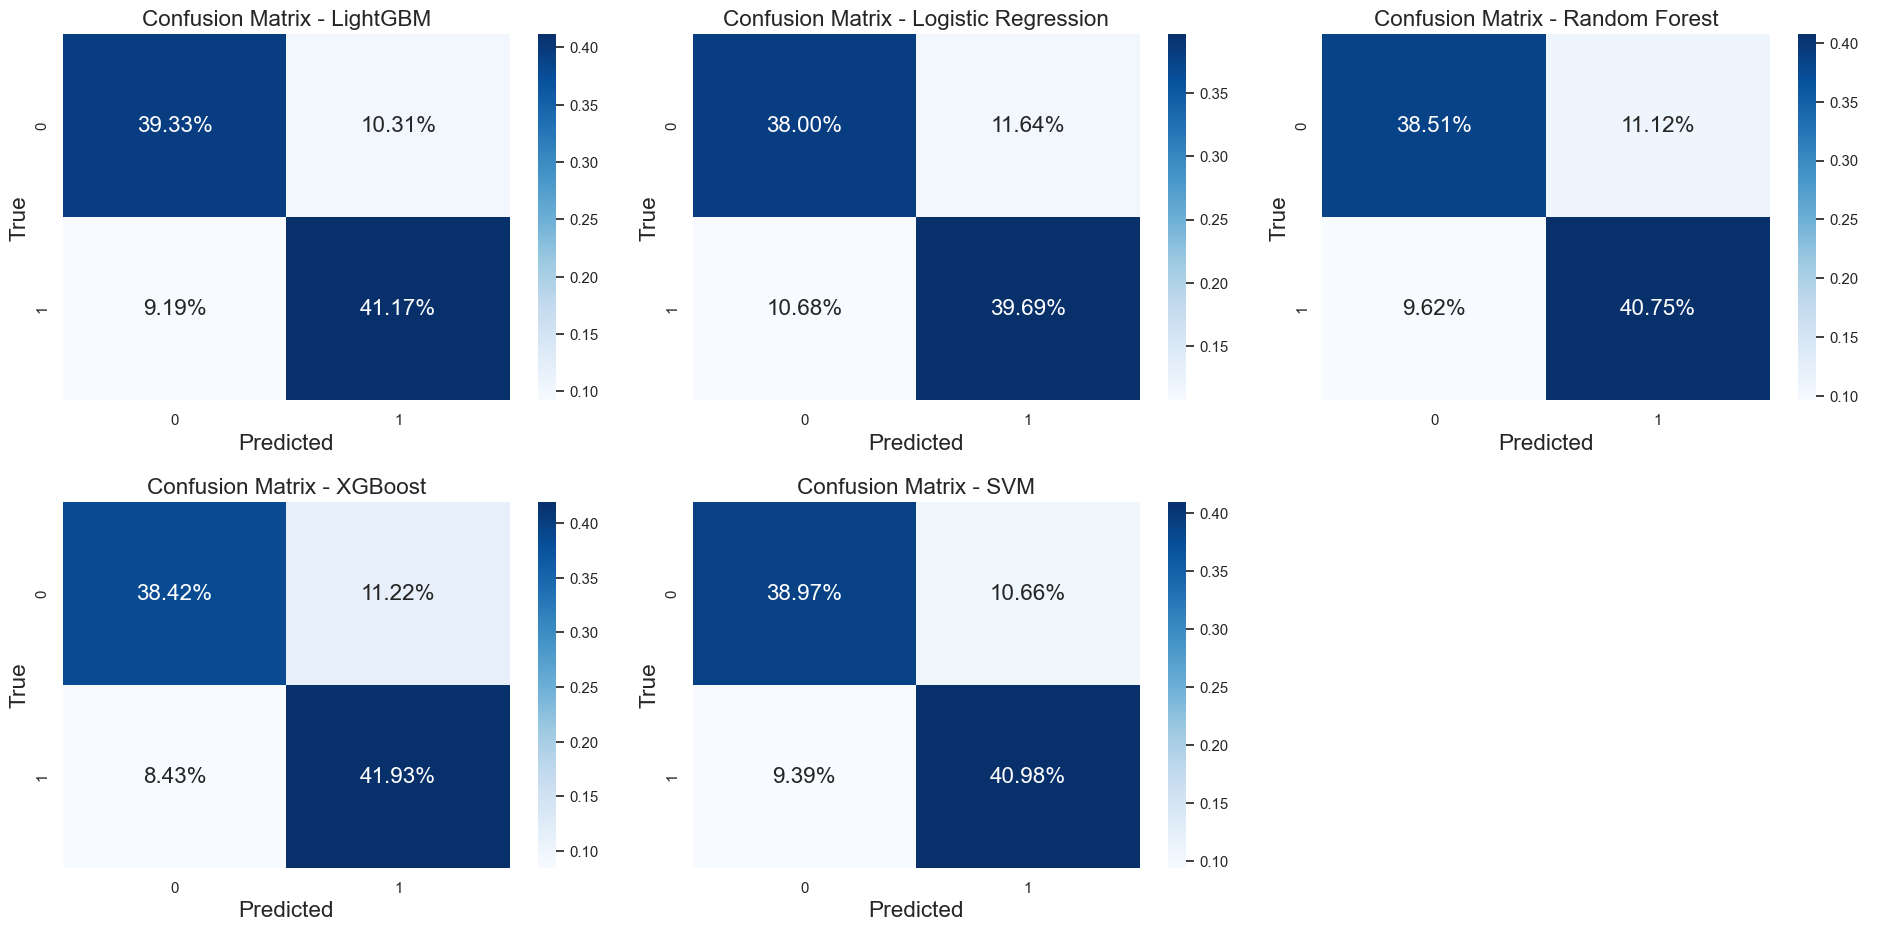

In [46]:
cols = 3
rows = len(fitted_models) % cols
fig_width = get_screen_width() / 100
_, axes = plt.subplots(
    nrows=rows, ncols=cols, figsize=(
        fig_width, fig_width / 2))
axes = axes.flatten()
i = 0

for model_name, model in fitted_models.items():
    y_pred = cross_val_predict(model, X, y, cv=kf)
    cm = confusion_matrix(y, y_pred)
    cm_normalized = cm.astype('float') / cm.sum()  # Normalize over the entire matrix
    sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', ax=axes[i])
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('True')
    axes[i].set_title(f'Confusion Matrix - {model_name}')

    df_performance.loc[df_performance['Model'] == model_name,
                       f'Model Acc Tuned'] = round(accuracy_score(y, y_pred), 3)

    i += 1

for j in range(i, rows * cols):
        axes[j].axis('off')

plt.tight_layout()
plt.show()

In [47]:
df_performance

,Model,Model Acc,Model Acc Tuned
0,LightGBM,0.804,0.805
1,Logistic Regression,0.773,0.777
2,Random Forest,0.789,0.793
3,XGBoost,0.802,0.804
4,SVM,0.772,0.799


<div class="results">
    <h3>Model Results</h3>
    <p>Tuned classifiers</p>
    <ol>
        <ul>Hyperparameter tuning improved all models slightly</ul>
        <ul>LightGBM retains the lead with a score of 80.5%</ul>
        <ul>Random Forest has the least false negatives</ul>
        <ul>XGBoost has the least false positives</ul>
    </ol>
</div>

## Model Ensembling - VotingClassifier
With all the models tuned, let's create a `VotingClassifier()` ensemble to see if we can get a better score.

Voting Classifier Accuracy: 80.3%


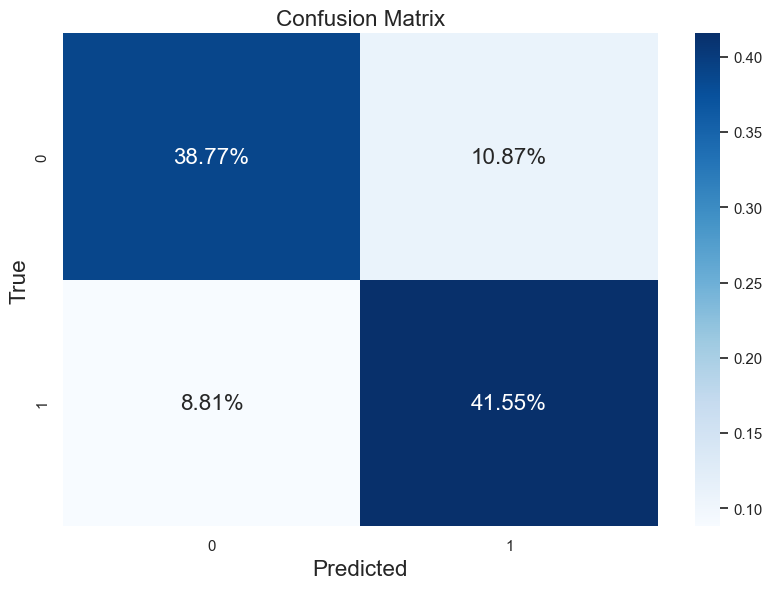

In [48]:
ensemble_voting = VotingClassifier(
    estimators=[
        ('lr', fitted_models['Logistic Regression']),
        ('rf', fitted_models['Random Forest']),
        ('xgb', fitted_models['XGBoost']),
        ('lgbm', fitted_models['LightGBM']),
        ('svm', fitted_models['SVM'])
    ],
    voting='soft'
)
 
# Cross-validation of the ensemble
y_pred = cross_val_predict(ensemble_voting, X, y, cv=kf)
model_voting = ensemble_voting.fit(X, y)
print(f'Voting Classifier Accuracy: {round(accuracy_score(y, y_pred), 3):.1%}')
draw_confusion_matrix(y, y_pred)

<div class="results">
    <h3>Model Results</h3>
    <p>VotingClassifier Ensemble</p>
    <ol>
        <ul>A solid model with second-best false negative result (behind SVM)</ul>
        <ul>Score of 80.4%, tied with XGBoost, slightly worse than LightGBM</ul>
    </ol>
</div>

## Model Ensembling - StackingClassifier
Let's try a more complex ensemble method - a `StackingClassifier()` ensemble to create a powerful meta-model.

Stacking Classifier Accuracy: 80.4%


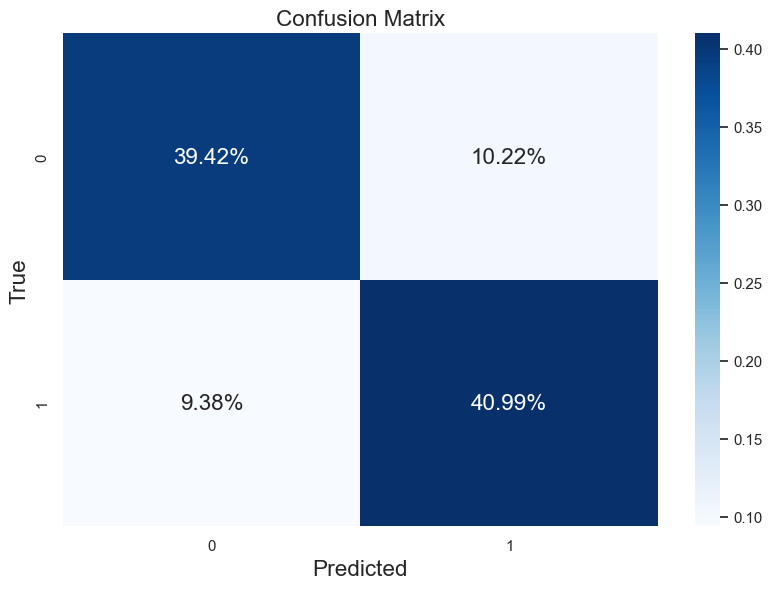

In [49]:
pipeline_steps = [
    ('num_scaler', StandardScaler()),
    ('feature_selection', SelectFromModel(LGBMClassifier(random_state=RANDOM_STATE, verbose=-1))),
    ('stacking', StackingClassifier(
        estimators=[
            ('lr', fitted_models['Logistic Regression']),
            ('rf', fitted_models['Random Forest']),
            ('xgb', fitted_models['XGBoost']),
            ('lgbm', fitted_models['LightGBM']),
            ('svm', fitted_models['SVM'])
        ],
        final_estimator=fitted_models['LightGBM']
    ))
]
ensemble_stacking = Pipeline(steps=pipeline_steps)

param_grid_stacking = {
    'num_scaler__with_mean': [True, False],
    'num_scaler__with_std': [True, False],

    'feature_selection__estimator__n_estimators': randint(50, 200),
    'feature_selection__estimator__num_leaves': randint(20, 100),
    'feature_selection__threshold': uniform(0.01, 0.3),

    'stacking__lr__model__C': [0.01, 0.1, 1, 10, 100],
    'stacking__rf__model__n_estimators': [50, 100, 200],
    'stacking__xgb__model__n_estimators': [50, 100, 200],
    'stacking__lgbm__model__num_leaves': [31, 50, 100],
    'stacking__svm__model__C': [0.1, 1, 10, 100],
    'stacking__final_estimator__model__num_leaves': [31, 50, 100]
}

grid_search_stacking = RandomizedSearchCV(
    ensemble_stacking,
    param_grid_stacking,
    cv=kf,
    scoring='accuracy',
    n_jobs=-1,
    random_state=RANDOM_STATE,
)
grid_search_stacking.fit(X, y)
best_model_stacking = grid_search_stacking.best_estimator_
y_pred = cross_val_predict(best_model_stacking, X, y, cv=kf)

print(f'Stacking Classifier Accuracy: {round(accuracy_score(y, y_pred), 3):.1%}')
draw_confusion_matrix(y, y_pred)

<div class="results">
    <h3>Model Results</h3>
    <p>StackingClassifier Ensemble</p>
    <ol>
        <ul>Surprisingly, a worse performer than <b>VotingClassifier</b> and the individual models</ul>
        <ul>Fairly balanced between false negatives and positives</ul>
    </ol>
</div>

## Model Ensembling - Weighted Average Ensemble
While `StackingClassifier()` did not produce a result we wanted, let's try a <b>Weighted Average Ensemble</b> that finds the optimal weights for combining the predictions of models.

In [50]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
models = []
for _, model in fitted_models.items():
    models.append(model)
    model.fit(X_train, y_train)

predictions = [model.predict_proba(X_val)[:, 1] for model in models]

starting_values = [1/len(models)] * len(models)
cons = ({'type':'eq','fun':lambda w: 1-sum(w)})
bounds = [(0,1)]*len(models)

res = minimize(log_loss_func, starting_values, args=(y_val, *predictions),
               method='SLSQP', bounds=bounds, constraints=cons)
optimized_weights = res.x

y_pred_weighted = weighted_average_ensemble(optimized_weights,
                                            *[model.predict_proba(X)[:, 1] for model in models])
y_pred_weighted_binary = (y_pred_weighted > 0.5).astype(int)

print(f'Weighted Average Ensemble Accuracy: {round(accuracy_score(y, y_pred_weighted_binary), 3):.1%}')
print('Optimized weights:', optimized_weights)

Weighted Average Ensemble Accuracy: 85.6%
Optimized weights: [7.32890054e-01 6.93889390e-18 4.85722573e-17 2.67109946e-01
 6.93889390e-18]


## Predictions Exporting
Let's prepare the testing dataset and export the results to the .csv file. We will use the following models:
* XGBoost
* LightGBM
* Voting Classifier
* Stacking Classifier
* Weighted Average Ensemble

In [51]:
# Format the test dataset
X_test = df_test.drop(['PassengerId'], axis=1)
X_test['BigSpender'] = X_test['BigSpender'].astype('category')
X_test['SinglePassenger'] = X_test['SinglePassenger'].astype('category')
numerical_columns = X_test.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_columns = X_test.select_dtypes(exclude=['int64', 'float64']).columns.tolist()
encoded = pd.get_dummies(X_test[categorical_columns], drop_first=True)
X_test = X_test[numerical_columns]
X_test = X_test.join(encoded)

def weighted_average_predict(models, weights, X):
    """Calculate weighted average predictions"""
    predictions = np.array([model.predict_proba(X)[:, 1] for model in models])
    return np.average(predictions, axis=0, weights=weights)
 
def export_weighted_ensemble_predictions(models, weights, submission_name):
    """Export weighted average ensemble model predictions to a csv file"""
    predictions = weighted_average_predict(models, weights, X_test)
    predictions_binary = (predictions > 0.5).astype(int)
    output = pd.DataFrame({'PassengerId': df_test['PassengerId'], 'Transported': predictions_binary})
    output['Transported'] = output['Transported'].map({1: True, 0: False})
    output.to_csv(f'{EXPORT_FOLDER}/submission_{submission_name}.csv', index=False)

def export_predictions(model, submission_name):
    """Export model predictions to a .csv file"""
    predictions = model.predict(X_test)
    output = pd.DataFrame({'PassengerId': df_test['PassengerId'], 'Transported': predictions})
    output['Transported'] = output['Transported'].map({1: True, 0: False})
    output.to_csv(f'{EXPORT_FOLDER}/submission_{submission_name}.csv', index=False)

EXPORT_FOLDER = 'exports'
export_predictions(model_voting, 'VotingClassifier')
export_predictions(best_model_stacking, 'StackingClassifier')
export_predictions(fitted_models['LightGBM'], 'LightGBM')
export_predictions(fitted_models['XGBoost'], 'XGBoost')
export_weighted_ensemble_predictions(models, optimized_weights, 'WeightedEnsemble')

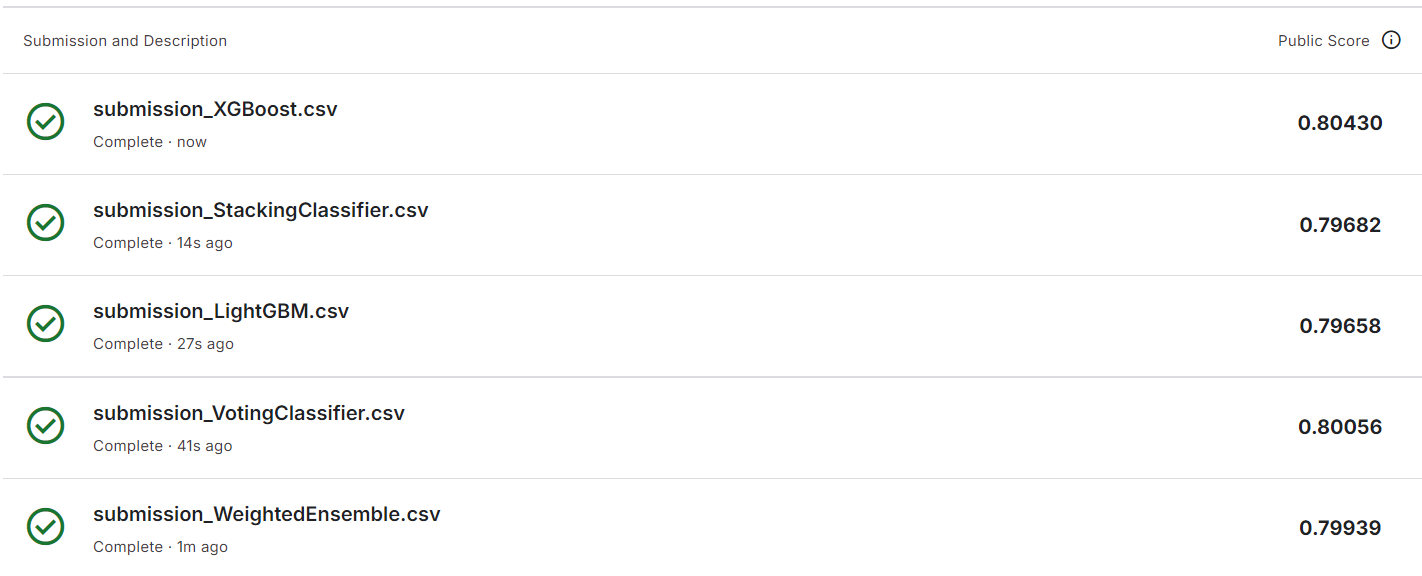

In [52]:
Image('media/scores.png')

# Summary
## Findings
The Spaceship Titanic dataset had opportunities for data imputation, transformation and new features' creation. The data for binary classification was very-well balanced. A total of 6 separate ML models were trained, with gradient `XGBoost` and `LightGBM` boosting algorithms having the best accuracy.

To further improve results, the study performed three ensembling methods - Voting Classification, Stacking Classification and Weighted Average Ensembling, combining the outputs of the six models into one. Out of these three methods, Voting Classification performed better, although **XGBoost** beat all models in the competition scoreboard. While weighted average ensembling showed a very good accuracy score of 85%+, it did not reach this score in the test dataset.

## Considerations
* Size of the dataset (~9000 passengers` for training data).
* Logic of the `Transported` label (at what stage of the trip did the passenger disappear).
* Missing data (~16% of the rows had at least one missing value)

## Improvements for Future Studies
* Test additional ML models. Gradient boosting algorithms, such as `AdaBoostClassifier` or `GradientBoostingClassifier` might yield great results.
* Alternative hyperparameter tuning approaches, such as `BayesSearchCV`, `optuna` or `hyperopt`